# Training

In [ ]:
!pip install -q langchain-community faiss-cpu sentence-transformers pypdf pdfplumber gradio trl rank_bm25 evaluate rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━

In [ ]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/llama-2-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    "unsloth/tinyllama-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit", # New Google 6 trillion tokens model 2.5x faster!
    "unsloth/gemma-2b-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.1: Fast Mistral patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.9.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""


EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass


In [ ]:
import os
if os.path.exists("/content/dataCombined.json"):
    print("File found!")
else:
    print("File not found. Please check the path and ensure the file is uploaded or correctly placed.")

from datasets import load_dataset
dataset = load_dataset("json", data_files="/content/dataCombined.json", split="train")
dataset = dataset.map(formatting_prompts_func, batched = True,)
dataset = dataset.train_test_split(test_size=0.2)


train_dataset = dataset["train"]
test_dataset = dataset["test"]

File found!


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
from sentence_transformers import SentenceTransformer, util
import evaluate

# Load models and metrics
sbert_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")
bleu_metric = evaluate.load("bleu")

def compute_metrics(eval_preds):
    predictions, labels = eval_preds

    if isinstance(predictions, tuple):
        predictions = predictions[0]

    predictions = predictions.argmax(axis=-1)
    predictions = predictions.tolist()
    labels = labels.tolist()

    decoded_preds = []
    decoded_labels = []

    for i in range(len(predictions)):
        label_ids = [id for id in labels[i] if id != -100]
        pred_ids = predictions[i][:len(label_ids)]

        decoded_preds.append(tokenizer.decode(pred_ids, skip_special_tokens=True).strip())
        decoded_labels.append(tokenizer.decode(label_ids, skip_special_tokens=True).strip())

    # BLEU-4 (default max_order=4)
    bleu_4 = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels]
    )

    # BLEU-2 (set max_order=2)
    bleu_2 = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels],
        max_order=2
    )

    # Semantic similarity (SBERT)
    embeddings_preds = sbert_model.encode(decoded_preds, convert_to_tensor=True)
    embeddings_labels = sbert_model.encode(decoded_labels, convert_to_tensor=True)
    cosine_scores = util.cos_sim(embeddings_preds, embeddings_labels).diagonal()
    avg_semantic_similarity = cosine_scores.mean().item()

    return {
        "bleu_4": bleu_4["bleu"],
        "bleu_2": bleu_2["bleu"],
        "semantic_similarity": avg_semantic_similarity
    }


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
from collections import defaultdict
from transformers import TrainerCallback

eval_results = defaultdict(list)
eval_steps = 5  # Evaluate every 5 steps

# Create a custom callback to evaluate periodically
# Inherit from TrainerCallback
class CustomEvalCallback(TrainerCallback):
    def __init__(self, trainer, eval_steps):
        self.trainer = trainer
        self.eval_steps = eval_steps

    # Add the required on_train_begin method with expected arguments
    def on_train_begin(self, args, state, control, **kwargs):
        pass

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % self.eval_steps == 0:
            # Pass evaluation strategy to evaluate method
            # The evaluate method expects the state and control objects
            eval_metrics = self.trainer.evaluate()
            eval_results["step"].append(state.global_step)
            eval_results["eval_loss"].append(eval_metrics.get("eval_loss"))
            # "bleu" is nested under "eval_bleu" in the returned dict
            eval_results["bleu"].append(eval_metrics.get("eval_bleu"))
            print(f"\nEvaluation at step {state.global_step}:")
            print(f"  Eval Loss: {eval_metrics.get('eval_loss')}")
            print(f"  BLEU-4: {eval_metrics.get('eval_bleu_4')}")
            print(f"  BLEU-2: {eval_metrics.get('eval_bleu_2')}")
            print(f"  Semantic Similarity: {eval_metrics.get('eval_semantic_similarity')}")
        return control

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported


# Use Huggingface TRL's SFTTrainer
training_args = TrainingArguments(
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,
    warmup_steps = 5,
    max_steps = 250,  # #######
    learning_rate = 2e-5,  # #######
    fp16 = False,
    # fp16 = not is_bfloat16_supported(),
    # bf16 = is_bfloat16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.1,  #######
    lr_scheduler_type = "linear",
    seed = 3407,
    output_dir = "outputs",
    report_to = "none",
    save_strategy = "steps",
    save_steps = 20,
)


trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = True,  # ##
    args = training_args,
    compute_metrics = compute_metrics,  ####
)

trainer.add_callback(CustomEvalCallback(trainer, eval_steps))

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/240 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/60 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()
eval_metrics = trainer.evaluate()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 240 | Num Epochs = 9 | Total steps = 250
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 7,283,675,136 (0.58% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,entropy
1,2.549000,0
2,2.484400,No Log
3,2.623600,No Log
4,2.181400,No Log
5,2.181400,No Log
6,2.469500,No Log
7,1.978200,No Log
8,1.682900,No Log
9,1.865400,No Log
10,1.865400,No Log


Unsloth: Not an error, but MistralForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient



Evaluation at step 5:
  Eval Loss: 2.3332228660583496
  BLEU-4: 0.30241386160011796
  BLEU-2: 0.4670909784670436
  Semantic Similarity: 0.882777750492096

Evaluation at step 10:
  Eval Loss: 1.8094158172607422
  BLEU-4: 0.40099475358685077
  BLEU-2: 0.5347119958643002
  Semantic Similarity: 0.9071251749992371

Evaluation at step 15:
  Eval Loss: 1.54623281955719
  BLEU-4: 0.4208229156968881
  BLEU-2: 0.5523221440153745
  Semantic Similarity: 0.907547116279602

Evaluation at step 20:
  Eval Loss: 1.3511543273925781
  BLEU-4: 0.5078615923181837
  BLEU-2: 0.6297043505896908
  Semantic Similarity: 0.9139092564582825

Evaluation at step 25:
  Eval Loss: 1.2146892547607422
  BLEU-4: 0.525876602851736
  BLEU-2: 0.6462131059139914
  Semantic Similarity: 0.9161251783370972

Evaluation at step 30:
  Eval Loss: 1.1229499578475952
  BLEU-4: 0.5663448241614008
  BLEU-2: 0.6780199570917863
  Semantic Similarity: 0.9196367263793945

Evaluation at step 35:
  Eval Loss: 1.0822014808654785
  BLEU-4: 0.

In [ ]:
train_loss = trainer_stats.training_loss if hasattr(trainer_stats, 'training_loss') else None
eval_loss = eval_metrics.get("eval_loss", None)
bleu_4 = eval_metrics.get("eval_bleu_4", None)
bleu_2 = eval_metrics.get("eval_bleu_2", None)
semantic_score = eval_metrics.get("eval_semantic_similarity", None)
perplexity = torch.exp(torch.tensor(eval_loss)) if eval_loss is not None else None

print(f"\nTrain Loss: {train_loss}")
print(f"Eval Loss: {eval_loss}")
print(f"BLEU-4 Score: {bleu_4}")
print(f"BLEU-2 Score: {bleu_2}")
print(f"Semantic Similarity: {semantic_score}")
print(f"Perplexity: {perplexity}")

print("\n=== Evaluation Metrics ===")
print(eval_metrics)




Train Loss: 0.8723807275295258
Eval Loss: 0.9086608290672302
BLEU-4 Score: 0.6169780579423486
BLEU-2 Score: 0.7208826462141134
Semantic Similarity: 0.9263838529586792
Perplexity: 2.4809978008270264

=== Evaluation Metrics ===
{'eval_loss': 0.9086608290672302, 'eval_bleu_4': 0.6169780579423486, 'eval_bleu_2': 0.7208826462141134, 'eval_semantic_similarity': 0.9263838529586792, 'eval_runtime': 14.6603, 'eval_samples_per_second': 4.093, 'eval_steps_per_second': 0.546, 'epoch': 8.333333333333334}


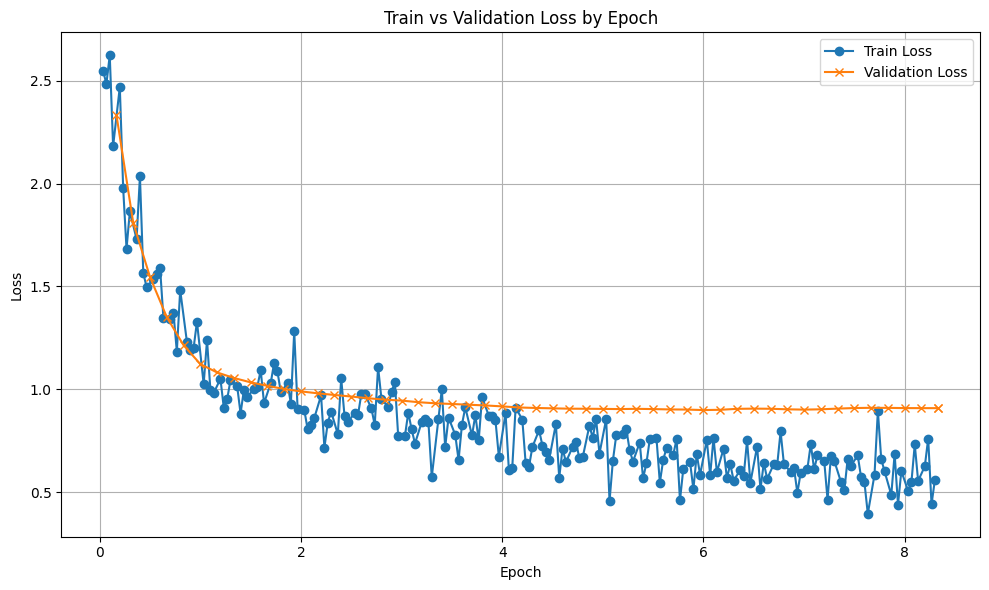

In [ ]:
import matplotlib.pyplot as plt

# Collect epoch-wise train and eval losses
train_epochs = []
train_losses = []
eval_epochs = []
eval_losses = []

for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:
        train_epochs.append(log['epoch'])
        train_losses.append(log['loss'])
    elif 'eval_loss' in log and 'epoch' in log:
        eval_epochs.append(log['epoch'])
        eval_losses.append(log['eval_loss'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label="Train Loss", marker='o')
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker='x')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss by Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# RAG (BM25 + FAISS )

In [ ]:
from unsloth import FastLanguageModel
import torch
from sentence_transformers import SentenceTransformer, CrossEncoder, util
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from rank_bm25 import BM25Okapi
import pdfplumber
import numpy as np
import logging
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download("punkt")
nltk.download("stopwords")
nltk.download('punkt_tab')


stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

sbert_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")
cross_encoder = CrossEncoder("BAAI/bge-reranker-large")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=150,
    separators=["\n\n", "\n", ". "]
)

embeddings = HuggingFaceEmbeddings(
    model_name="mixedbread-ai/mxbai-embed-large-v1",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

def tokenize(text):
    return [
        stemmer.stem(w)
        for w in word_tokenize(text.lower())
        if w.isalnum() and w.lower() not in stop_words
    ]

def load_document(file_path):
    if file_path.endswith(".pdf"):
        with pdfplumber.open(file_path) as pdf:
            text = "\n".join([page.extract_text() or '' for page in pdf.pages])
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
    if not text.strip():
        raise ValueError("Document is empty or could not be parsed.")
    return text

def normalize_output(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[\•\-\–\*]\s+', '', text)
    text = re.sub(r'\b\d+\.\s+', '', text)
    text = re.sub(r'\.(\S)', r'. \1', text)
    return text.strip()


def create_hybrid_db(file_path):
    try:
        text = load_document(file_path)
        chunks = text_splitter.split_text(text)
        chunks = [c for c in chunks if len(c.split()) > 10 and len(c.strip()) > 30]
        tokenized_chunks = [tokenize(chunk) for chunk in chunks]
        bm25 = BM25Okapi(tokenized_chunks)
        faiss = FAISS.from_texts(chunks, embeddings, distance_strategy="METRIC_INNER_PRODUCT")
        return {
            "chunks": chunks,
            "tokenized": tokenized_chunks,
            "bm25": bm25,
            "faiss": faiss
        }
    except Exception as e:
        print(f"[ERROR] Failed to load document: {e}")
        return None


/tmp/ipython-input-68966539.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


In [ ]:
def retrieve_context(question, db, k=5, top_k=1, alpha=0.5, beta=0.5):
    threshold = 40.0
    sbert_threshold = 0.60
    if db is None:
        return "No context found.", 0.0

    bm25_chunks = db["chunks"]
    bm25 = db["bm25"]
    faiss = db["faiss"]

    # 1. Get BM25 scores and top-k chunks
    bm25_scores_raw = bm25.get_scores(tokenize(question))
    top_bm25 = sorted(zip(bm25_chunks, bm25_scores_raw), key=lambda x: x[1], reverse=True)[:k]

    # 2. Get FAISS results (chunks + scores)
    faiss_results = faiss.similarity_search_with_score(question, k=k)
    top_faiss = [(doc.page_content, score) for doc, score in faiss_results]

    # 3. Create a unified list of unique chunks from both results
    # Normalize text to avoid duplicates (map normalized text to original chunk)
    combined_chunks_dict = {}
    for chunk, score in top_bm25 + top_faiss:
        norm_chunk = normalize_output(chunk)
        # If duplicates, keep the max score seen (temporary, will recompute combined later)
        if norm_chunk not in combined_chunks_dict:
            combined_chunks_dict[norm_chunk] = {
                "original": chunk,
                "bm25_score": 0.0,
                "faiss_score": 0.0
            }

    # 4. Assign BM25 scores to candidates where applicable
    bm25_scores_map = {normalize_output(c): s for c, s in top_bm25}
    for norm_chunk in combined_chunks_dict:
        if norm_chunk in bm25_scores_map:
            combined_chunks_dict[norm_chunk]["bm25_score"] = bm25_scores_map[norm_chunk]

    # 5. Assign FAISS scores similarly
    faiss_scores_map = {normalize_output(c): s for c, s in top_faiss}
    for norm_chunk in combined_chunks_dict:
        if norm_chunk in faiss_scores_map:
            combined_chunks_dict[norm_chunk]["faiss_score"] = faiss_scores_map[norm_chunk]

    # 6. Normalize BM25 and FAISS scores to [0,1]
    bm25_vals = [v["bm25_score"] for v in combined_chunks_dict.values()]
    faiss_vals = [v["faiss_score"] for v in combined_chunks_dict.values()]

    def normalize_scores(scores):
        min_s = min(scores)
        max_s = max(scores)
        if max_s - min_s == 0:
            return [0.0 for _ in scores]
        return [(s - min_s) / (max_s - min_s) for s in scores]

    bm25_norm = normalize_scores(bm25_vals)
    faiss_norm = normalize_scores(faiss_vals)

    # 7. Compute combined score per chunk
    for i, norm_chunk in enumerate(combined_chunks_dict):
        combined_chunks_dict[norm_chunk]["combined_score"] = (
            alpha * faiss_norm[i] + (1 - alpha) * bm25_norm[i]
        )

    # 8. Sort candidates by combined score descending
    sorted_candidates = sorted(
        combined_chunks_dict.values(),
        key=lambda x: x["combined_score"],
        reverse=True
    )

    # 9. Select top candidates for reranking
    candidates_for_rerank = [c["original"] for c in sorted_candidates[:k]]

    # 10. CrossEncoder reranking
    pairs = [(question, chunk) for chunk in candidates_for_rerank]
    rerank_scores = cross_encoder.predict(pairs, batch_size=8)
    reranked = sorted(zip(candidates_for_rerank, rerank_scores), key=lambda x: x[1], reverse=True)

    top_chunks = [chunk for chunk, _ in reranked[:top_k]]
    avg_score = np.mean([score for _, score in reranked[:top_k]])
    confidence = 1 / (1 + np.exp(-avg_score)) * 100

    sbert_sim = util.cos_sim(
        sbert_model.encode(question, convert_to_tensor=True),
        sbert_model.encode(" ".join(top_chunks), convert_to_tensor=True)
    ).item()

    print(f"[INFO] Cross-encoder confidence: {confidence:.2f}%, SBERT similarity: {sbert_sim:.2f}")

    if confidence < threshold or sbert_sim < sbert_threshold:
        return "No relevant clause was found.", confidence

    return f"[Document Context]: {normalize_output(top_chunks[0])}", confidence


In [ ]:
def answer_with_rag(question, db, gold_chunk=None):
    context, score = retrieve_context(question, db, alpha=alpha, beta=beta)
    print("=== RETRIEVED CONTEXT ===")
    print(context)
    print(f"\nSimilarity Score: {score:.2f}%\n")

    if gold_chunk:
        sbert_sim = util.cos_sim(
            sbert_model.encode(context, convert_to_tensor=True),
            sbert_model.encode(gold_chunk, convert_to_tensor=True)
        ).item() * 100
        print(f"SBERT Similarity (retrieved vs gold): {sbert_sim:.2f}%")

    prompt = alpaca_prompt.format(question, context, "")
   # prompt = alpaca_prompt.format(context, question, "" )
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    outputs = model.generate(**inputs, max_new_tokens=256)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = answer.split("### Response:")[-1].strip()

    print("=== MODEL ANSWER ===")
    print(answer)
    return answer


## Retrieval Evaluation

In [ ]:
import os
import json
import math
import numpy as np
from glob import glob
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, CrossEncoder, util

# === Load Models ===
sbert = sbert_model
cross = cross_encoder

# === Similarity-based Hit for QA
def contains_answer_semantically(gold_answer, docs, threshold=0.75):
    gold_emb = sbert.encode(gold_answer, convert_to_tensor=True)
    doc_embs = sbert.encode(docs, convert_to_tensor=True)
    sims = util.cos_sim(gold_emb, doc_embs)[0]
    return any(sim.item() > threshold for sim in sims)

# === NDCG Calculation
def compute_ndcg(relevance, k):
    dcg = 0.0
    for i in range(min(k, len(relevance))):
        if relevance[i]:
            dcg += 1 / math.log2(i + 2)

    # IDCG is the DCG of the ideal ranking (sorted relevance)
    ideal_relevance = sorted(relevance, reverse=True)
    idcg = 0.0
    for i in range(min(k, len(ideal_relevance))):
        if ideal_relevance[i]:
            idcg += 1 / math.log2(i + 2)

    return dcg / idcg if idcg > 0 else 0.0


In [ ]:
# === Parameters ===
test_dir = "/content/sample_data/tests"
json_files = glob(os.path.join(test_dir, "*.json"))
top_k = 3
similarity_threshold = 0.6

retrieval_precisions, retrieval_recalls, retrieval_f1s = [], [], []
average_precisions, reciprocal_ranks, ndcgs = [], [], []
semantic_answer_hits = 0
total_sbert_sim = 0.0
total = 0
soft_hits = 0

# === Evaluation Loop ===

for file in json_files:
    base = os.path.basename(file).replace(".json", "")
    pdf_path = os.path.join(test_dir, f"{base}.pdf")

    with open(file, "r", encoding="utf-8") as f:
        samples = json.load(f)

    db = create_hybrid_db(pdf_path)
    if db is None:
        continue

    for s in tqdm(samples, desc=base):
        question = s["instruction"]
        gold_chunk = normalize_output(s["input"])
        gold_answer = s["output"].lower()

        bm25_chunks = db["chunks"]
        bm25 = db["bm25"]
        faiss = db["faiss"]

        # Get raw BM25 scores for all chunks, keep top_k from BM25
        bm25_scores_raw = bm25.get_scores(tokenize(question))
        top_bm25 = sorted(zip(bm25_chunks, bm25_scores_raw), key=lambda x: x[1], reverse=True)[:top_k]

        # Get FAISS top_k results (chunk + score)
        faiss_results = faiss.similarity_search_with_score(question, k=top_k)
        top_faiss = [(doc.page_content, score) for doc, score in faiss_results]

        # Merge candidates (normalize to avoid duplicates)
        combined_chunks_dict = {}
        for chunk, score in top_bm25 + top_faiss:
            norm_chunk = normalize_output(chunk)
            if norm_chunk not in combined_chunks_dict:
                combined_chunks_dict[norm_chunk] = {
                    "original": chunk,
                    "bm25_score": 0.0,
                    "faiss_score": 0.0
                }

        # Assign BM25 scores
        bm25_scores_map = {normalize_output(c): s for c, s in top_bm25}
        for norm_chunk in combined_chunks_dict:
            if norm_chunk in bm25_scores_map:
                combined_chunks_dict[norm_chunk]["bm25_score"] = bm25_scores_map[norm_chunk]

        # Assign FAISS scores
        faiss_scores_map = {normalize_output(c): s for c, s in top_faiss}
        for norm_chunk in combined_chunks_dict:
            if norm_chunk in faiss_scores_map:
                combined_chunks_dict[norm_chunk]["faiss_score"] = faiss_scores_map[norm_chunk]

        # Normalize BM25 and FAISS scores separately
        def normalize_scores(scores):
            min_s = min(scores)
            max_s = max(scores)
            if max_s - min_s == 0:
                return [0.0 for _ in scores]
            return [(s - min_s) / (max_s - min_s) for s in scores]

        bm25_vals = [v["bm25_score"] for v in combined_chunks_dict.values()]
        faiss_vals = [v["faiss_score"] for v in combined_chunks_dict.values()]

        bm25_norm = normalize_scores(bm25_vals)
        faiss_norm = normalize_scores(faiss_vals)

        # Compute combined scores (alpha weight can be adjusted)
        alpha = 0.5 # here it is called alpha, but in the paper alpha is the confidence threshold and this one has no name there.
        for i, norm_chunk in enumerate(combined_chunks_dict):
            combined_chunks_dict[norm_chunk]["combined_score"] = (
                alpha * faiss_norm[i] + (1 - alpha) * bm25_norm[i]
            )

        # Sort by combined score descending
        sorted_candidates = sorted(
            combined_chunks_dict.values(),
            key=lambda x: x["combined_score"],
            reverse=True
        )

        # Select top_k candidates for reranking
        candidates_for_rerank = [c["original"] for c in sorted_candidates[:top_k]]

        if not candidates_for_rerank:
            continue

        # Rerank with cross encoder
        pairs = [(question, chunk) for chunk in candidates_for_rerank]
        rerank_scores = cross.predict(pairs, batch_size=8)
        reranked = sorted(zip(candidates_for_rerank, rerank_scores), key=lambda x: x[1], reverse=True)
        top_chunks = [chunk for chunk, _ in reranked[:top_k]]

        # SBERT similarity for evaluation metrics
        sims = [
            util.cos_sim(sbert.encode(chunk, convert_to_tensor=True),
                         sbert.encode(gold_chunk, convert_to_tensor=True)).item()
            for chunk in top_chunks
        ]

        max_sim = max(sims)
        total_sbert_sim += max_sim
        total += 1
        if max_sim >= similarity_threshold:
            soft_hits += 1

        relevance_scores = [1 if sim >= similarity_threshold else 0 for sim in sims]
        precision = sum(relevance_scores) / top_k
        recall = 1.0 if any(relevance_scores) else 0.0
        f1 = (2 * precision * recall) / (precision + recall + 1e-8)

        retrieval_precisions.append(precision)
        retrieval_recalls.append(recall)
        retrieval_f1s.append(f1)

        ap = sum([(sum(relevance_scores[:i + 1]) / (i + 1)) * rel for i, rel in enumerate(relevance_scores)])
        average_precisions.append(ap / max(1, sum(relevance_scores)))

        try:
            rank = relevance_scores.index(1) + 1
            reciprocal_ranks.append(1 / rank)
        except ValueError:
            reciprocal_ranks.append(0)

        ndcgs.append(compute_ndcg(relevance_scores, top_k))

        if contains_answer_semantically(gold_answer, top_chunks):
            semantic_answer_hits += 1


netflix: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


In [ ]:
mean_precision = sum(retrieval_precisions) / len(retrieval_precisions)
mean_recall = sum(retrieval_recalls) / len(retrieval_recalls)
mean_f1 = sum(retrieval_f1s) / len(retrieval_f1s)
mean_ap = sum(average_precisions) / len(average_precisions)
mean_rr = sum(reciprocal_ranks) / len(reciprocal_ranks)
mean_ndcg = sum(ndcgs) / len(ndcgs)

print("\n📈 Retrieval Ranking Metrics")
print(f"Num Questions: {total}")
print(f"SoftRecall@{top_k} (SBERT ≥ {similarity_threshold*100:.0f}%): {soft_hits / total:.4f}")
print(f"AnswerRecall@{top_k} (Answer in any retrieved chunk): {semantic_answer_hits / total:.4f}")
print(f"Avg SBERT Similarity: {total_sbert_sim / total:.4f}")

print(f"Precision@{top_k}: {mean_precision:.4f}")
print(f"Recall@{top_k}   : {mean_recall:.4f}")
print(f"F1@{top_k}       : {mean_f1:.4f}")
print(f"MAP              : {mean_ap:.4f}")
print(f"MRR              : {mean_rr:.4f}")
print(f"NDCG@{top_k}     : {mean_ndcg:.4f}")




📈 Retrieval Ranking Metrics
Num Questions: 165
SoftRecall@3 (SBERT ≥ 60%): 0.9879
AnswerRecall@3 (Answer in any retrieved chunk): 0.5758
Avg SBERT Similarity: 0.8537
Precision@3: 0.9051
Recall@3   : 0.9879
F1@3       : 0.9339
MAP              : 0.9677
MRR              : 0.9747
NDCG@3     : 0.9750


# Full pipeline evaluation


In [ ]:
# === Setup & Helpers ===
import os
import json
from glob import glob
from tqdm import tqdm
import torch
import nltk
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer, util
from evaluate import load

sbert = sbert_model
bleu = load("bleu")
rouge = load("rouge")

# === Evaluation Helpers ===
def binary_token_overlap(preds, labels):
    total_tp = total_fp = total_fn = 0
    for pred, label in zip(preds, labels):
        pred_tokens = set(word_tokenize(pred.lower()))
        label_tokens = set(word_tokenize(label.lower()))

        tp = len(pred_tokens & label_tokens)
        fp = len(pred_tokens - label_tokens)
        fn = len(label_tokens - pred_tokens)

        total_tp += tp
        total_fp += fp
        total_fn += fn

    prec = total_tp / (total_tp + total_fp + 1e-8)
    rec = total_tp / (total_tp + total_fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    return prec, rec, f1

def compute_perplexity(model, tokenizer, prompts, responses):
    model.eval()
    losses = []
    for prompt, resp in zip(prompts, responses):
        full_input = prompt + resp
        encodings = tokenizer(full_input, return_tensors="pt").to(model.device)
        labels = tokenizer(resp, return_tensors="pt").input_ids.to(model.device)
        labels = torch.cat([torch.full_like(encodings["input_ids"][:, :-labels.shape[1]], -100), labels], dim=1)

        with torch.no_grad():
            outputs = model(**encodings, labels=labels)
        losses.append(outputs.loss.item())
    return torch.exp(torch.tensor(losses)).mean().item()


def answer_with_combined_rag(question, hybrid_db, gold_chunk=None, alpha=0.5, beta=0.5):
    context, score = retrieve_context(question, hybrid_db, alpha=alpha, beta=beta)
    print("=== RETRIEVED CONTEXT ===")
    print(context)
    print(f"\nSimilarity Score: {score:.2f}%\n")

    if gold_chunk:
        sbert_sim = util.cos_sim(
            sbert.encode(context, convert_to_tensor=True),
            sbert.encode(gold_chunk, convert_to_tensor=True)
        ).item() * 100
        print(f"SBERT Similarity (retrieved vs gold): {sbert_sim:.2f}%")

    prompt = alpaca_prompt.format(question, context, "")
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=256)



    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = answer.split("### Response:")[-1].strip()

    print("=== MODEL ANSWER ===")
    print(answer)
    return answer



In [ ]:
# ===  Evaluation Loop ===
test_dir = "/content/sample_data/tests"
json_files = glob(os.path.join(test_dir, "*.json"))

all_preds, all_labels, all_prompts = [], [], []

for file in json_files:
    base = os.path.basename(file).replace(".json", "")
    pdf_path = os.path.join(test_dir, f"{base}.pdf")

    with open(file, "r", encoding="utf-8") as f:
        samples = json.load(f)

    hybrid_db = create_hybrid_db(pdf_path)
    if hybrid_db is None:
        continue

    for s in tqdm(samples, desc=base):
        question = s["instruction"]
        gold_chunk = normalize_output(s["input"])
        gold_answer = s["output"]

        try:
            answer = answer_with_combined_rag(question, hybrid_db, gold_chunk)
        except Exception as e:
            print(f"[ERROR] Failed: {question[:40]}... -> {e}")
            answer = ""

        prompt = alpaca_prompt.format(question, gold_chunk, "")
        all_prompts.append(prompt)
        all_preds.append(answer)
        all_labels.append(gold_answer)



snap:   0%|          | 0/64 [00:00<?, ?it/s]

[INFO] Cross-encoder confidence: 50.55%, SBERT similarity: 0.64
=== RETRIEVED CONTEXT ===
[Document Context]: how to delete data or your account. We want you to be in control of your information, so we provide you with a range of tools, including: Access and update your information. You can access and edit most of your basic account information right in our Services. Just navigate to your settings and you will see the options available to you. Delete your information. If you want to delete your

Similarity Score: 50.55%

SBERT Similarity (retrieved vs gold): 82.03%


snap:   2%|▏         | 1/64 [00:02<02:59,  2.85s/it]

=== MODEL ANSWER ===
You can access and edit most of your basic account information right in our Services. Just navigate to your settings and you will see the options available to you.
[INFO] Cross-encoder confidence: 52.09%, SBERT similarity: 0.69
=== RETRIEVED CONTEXT ===
[Document Context]: how to delete data or your account. We want you to be in control of your information, so we provide you with a range of tools, including: Access and update your information. You can access and edit most of your basic account information right in our Services. Just navigate to your settings and you will see the options available to you. Delete your information. If you want to delete your

Similarity Score: 52.09%

SBERT Similarity (retrieved vs gold): 82.03%


snap:   3%|▎         | 2/64 [00:05<02:48,  2.72s/it]

=== MODEL ANSWER ===
Yes, you can access and edit most of your account information in the settings. You can also delete your account and all the data associated with it.
[INFO] Cross-encoder confidence: 52.75%, SBERT similarity: 0.62
=== RETRIEVED CONTEXT ===
[Document Context]: long to keep your information: If we need the information to operate or provide our Services. For example, we store your basic account details — like your name, phone number, and email address — to maintain your account. To do the things you expect from our Services and as we’ve described within this Privacy Policy. For example, we maintain your list of friends until you ask us to delete them

Similarity Score: 52.75%

SBERT Similarity (retrieved vs gold): 69.91%


snap:   5%|▍         | 3/64 [00:07<02:36,  2.56s/it]

=== MODEL ANSWER ===
You can update your basic account details like your name, phone number, and email address in your account settings.
[INFO] Cross-encoder confidence: 58.30%, SBERT similarity: 0.67
=== RETRIEVED CONTEXT ===
[Document Context]: are findable to others through your phone number and/or email address that you provided. If you no longer want to be findable, you can always change your settings. Or if you provided access to your phone or third party platform contacts to make friending easier, you can change that later on in your app settings. Of course, if you do that,

Similarity Score: 58.30%

SBERT Similarity (retrieved vs gold): 63.71%


snap:   6%|▋         | 4/64 [00:10<02:24,  2.40s/it]

=== MODEL ANSWER ===
Yes, you can change your information in the app settings.
[INFO] Cross-encoder confidence: 50.01%, SBERT similarity: 0.65
=== RETRIEVED CONTEXT ===
[Document Context]: how to delete data or your account. We want you to be in control of your information, so we provide you with a range of tools, including: Access and update your information. You can access and edit most of your basic account information right in our Services. Just navigate to your settings and you will see the options available to you. Delete your information. If you want to delete your

Similarity Score: 50.01%

SBERT Similarity (retrieved vs gold): 82.03%


snap:   8%|▊         | 5/64 [00:12<02:21,  2.40s/it]

=== MODEL ANSWER ===
No, you can usually make changes to your account settings yourself, like updating your email address or deleting your account.
[INFO] Cross-encoder confidence: 50.15%, SBERT similarity: 0.68
=== RETRIEVED CONTEXT ===
[Document Context]: how to delete data or your account. We want you to be in control of your information, so we provide you with a range of tools, including: Access and update your information. You can access and edit most of your basic account information right in our Services. Just navigate to your settings and you will see the options available to you. Delete your information. If you want to delete your

Similarity Score: 50.15%

SBERT Similarity (retrieved vs gold): 82.03%


snap:   9%|▉         | 6/64 [00:15<02:27,  2.53s/it]

=== MODEL ANSWER ===
You can access and edit most of your basic account information right in our Services. Just navigate to your settings and you will see the options available to you.
[INFO] Cross-encoder confidence: 70.17%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: Snapchat experience. You can access, update, and delete your information, decide who can contact you, and download your data from within the Snapchat app. Below, we give you more details on the types of settings that are available, link out to our data download tool, and provide instructions on how to delete data or your account. We want you to be in control of your information, so we

Similarity Score: 70.17%

SBERT Similarity (retrieved vs gold): 68.40%


snap:  11%|█         | 7/64 [00:19<03:01,  3.19s/it]

=== MODEL ANSWER ===
You can delete your account by going to the Account Information page in the Snapchat app, then tap 'Delete Account'. You'll need to enter your password to confirm. Deleting your account will remove your profile information but may not delete all information in our systems or backups.
[INFO] Cross-encoder confidence: 71.17%, SBERT similarity: 0.63
=== RETRIEVED CONTEXT ===
[Document Context]: Services. Just navigate to your settings and you will see the options available to you. Delete your information. If you want to delete your account, learn how here. You can also delete some information within our Services, like content you’ve saved to Memories, content you’ve shared with My AI, Spotlight submissions, and more. Control who can see your content. We’ve built a number

Similarity Score: 71.17%

SBERT Similarity (retrieved vs gold): 88.14%


snap:  12%|█▎        | 8/64 [00:22<02:53,  3.09s/it]

=== MODEL ANSWER ===
Yes, you can delete some content like saved Memories, Spotlight submissions, and more within the app settings.
[INFO] Cross-encoder confidence: 72.98%, SBERT similarity: 0.70
=== RETRIEVED CONTEXT ===
[Document Context]: Services. Just navigate to your settings and you will see the options available to you. Delete your information. If you want to delete your account, learn how here. You can also delete some information within our Services, like content you’ve saved to Memories, content you’ve shared with My AI, Spotlight submissions, and more. Control who can see your content. We’ve built a number

Similarity Score: 72.98%

SBERT Similarity (retrieved vs gold): 88.14%


snap:  14%|█▍        | 9/64 [00:25<02:37,  2.87s/it]

=== MODEL ANSWER ===
Yes, you can delete some data like content you’ve saved, shared with My AI, and Spotlight submissions.
[INFO] Cross-encoder confidence: 60.03%, SBERT similarity: 0.78
=== RETRIEVED CONTEXT ===
[Document Context]: Snapchat experience. You can access, update, and delete your information, decide who can contact you, and download your data from within the Snapchat app. Below, we give you more details on the types of settings that are available, link out to our data download tool, and provide instructions on how to delete data or your account. We want you to be in control of your information, so we

Similarity Score: 60.03%

SBERT Similarity (retrieved vs gold): 68.40%


snap:  16%|█▌        | 10/64 [00:27<02:24,  2.68s/it]

=== MODEL ANSWER ===
You can delete your account, account information, and download your data from within the Snapchat app.
[INFO] Cross-encoder confidence: 61.23%, SBERT similarity: 0.74
=== RETRIEVED CONTEXT ===
[Document Context]: Snapchat experience. You can access, update, and delete your information, decide who can contact you, and download your data from within the Snapchat app. Below, we give you more details on the types of settings that are available, link out to our data download tool, and provide instructions on how to delete data or your account. We want you to be in control of your information, so we

Similarity Score: 61.23%

SBERT Similarity (retrieved vs gold): 68.40%


snap:  17%|█▋        | 11/64 [00:29<02:11,  2.48s/it]

=== MODEL ANSWER ===
No, you can delete your data or account directly from the Snapchat app settings.
[INFO] Cross-encoder confidence: 68.67%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: Snapchat experience. You can access, update, and delete your information, decide who can contact you, and download your data from within the Snapchat app. Below, we give you more details on the types of settings that are available, link out to our data download tool, and provide instructions on how to delete data or your account. We want you to be in control of your information, so we

Similarity Score: 68.67%

SBERT Similarity (retrieved vs gold): 68.40%


snap:  19%|█▉        | 12/64 [00:31<02:09,  2.49s/it]

=== MODEL ANSWER ===
You can delete your account by going to the Account Information page in the Snapchat app or website, and following the instructions there.
[INFO] Cross-encoder confidence: 72.63%, SBERT similarity: 0.79
=== RETRIEVED CONTEXT ===
[Document Context]: there are some moments you want to share privately with your close friends, and others that you want to share publicly. That’s why from day one our philosophy has been to delete content by default and to give Snapchatters control by providing the tools that allow them to decide what happens with their content, like who to share it with or when to save it.

Similarity Score: 72.63%

SBERT Similarity (retrieved vs gold): 75.30%


snap:  20%|██        | 13/64 [00:34<02:06,  2.49s/it]

=== MODEL ANSWER ===
Yes, you can control who sees your content by setting your Snapchat privacy settings.
[INFO] Cross-encoder confidence: 54.16%, SBERT similarity: 0.78
=== RETRIEVED CONTEXT ===
[Document Context]: there are some moments you want to share privately with your close friends, and others that you want to share publicly. That’s why from day one our philosophy has been to delete content by default and to give Snapchatters control by providing the tools that allow them to decide what happens with their content, like who to share it with or when to save it.

Similarity Score: 54.16%

SBERT Similarity (retrieved vs gold): 75.30%


snap:  22%|██▏       | 14/64 [00:36<02:00,  2.41s/it]

=== MODEL ANSWER ===
Snapchat allows users to manage content visibility by providing tools to share with close friends or save content.
[INFO] Cross-encoder confidence: 73.05%, SBERT similarity: 0.79
=== RETRIEVED CONTEXT ===
[Document Context]: Friends are on Snapchat or which friends you may be sharing your location with. We do not share message content. Learn more. Public. Most of the features on Snapchat are private and for Friends only, but we also offer public features that allow you to opt in to showcase your best Snaps to the world, such as Spotlight, Snap Map, or your Public Profile.

Similarity Score: 73.05%

SBERT Similarity (retrieved vs gold): 65.20%


snap:  23%|██▎       | 15/64 [00:40<02:16,  2.78s/it]

=== MODEL ANSWER ===
Yes, you can choose to share your content only with your friends on Snapchat. However, some features like Snap Map and Spotlight are public by default, but you can adjust your settings to change that.
[INFO] Cross-encoder confidence: 73.05%, SBERT similarity: 0.81
=== RETRIEVED CONTEXT ===
[Document Context]: Friends are on Snapchat or which friends you may be sharing your location with. We do not share message content. Learn more. Public. Most of the features on Snapchat are private and for Friends only, but we also offer public features that allow you to opt in to showcase your best Snaps to the world, such as Spotlight, Snap Map, or your Public Profile.

Similarity Score: 73.05%

SBERT Similarity (retrieved vs gold): 65.20%


snap:  25%|██▌       | 16/64 [00:42<02:13,  2.78s/it]

=== MODEL ANSWER ===
Yes, Snapchat offers public features like Spotlight, Snap Map, and Public Profiles, but you must opt-in to use them.
[INFO] Cross-encoder confidence: 52.29%, SBERT similarity: 0.58
=== RETRIEVED CONTEXT ===
No relevant clause was found.

Similarity Score: 52.29%

SBERT Similarity (retrieved vs gold): 34.14%


snap:  27%|██▋       | 17/64 [00:45<02:10,  2.77s/it]

=== MODEL ANSWER ===
You can control the visibility of your content by adjusting your privacy settings. Please refer to our Privacy Policy for more information.
[INFO] Cross-encoder confidence: 67.64%, SBERT similarity: 0.73
=== RETRIEVED CONTEXT ===
[Document Context]: to Memories, content you’ve shared with My AI, Spotlight submissions, and more. Control who can see your content. We’ve built a number of tools that let you choose who you share your content with. In some cases you may want to share content with your friends, and in other instances you may want to share it with the public. To learn more, go here.

Similarity Score: 67.64%

SBERT Similarity (retrieved vs gold): 89.55%


snap:  28%|██▊       | 18/64 [00:48<02:02,  2.66s/it]

=== MODEL ANSWER ===
Snapchat provides tools to help you control who can see your content, including sharing with friends or the public.
[INFO] Cross-encoder confidence: 73.01%, SBERT similarity: 0.85
=== RETRIEVED CONTEXT ===
[Document Context]: your friends, and in other instances you may want to share it with the public. To learn more, go here. Control who can contact you. Snapchat is intended for close friends and family, that’s why we’ve built controls that help you decide who can contact you. If you receive unwanted communications, you can always block and report that person. Go here to learn more.

Similarity Score: 73.01%

SBERT Similarity (retrieved vs gold): 93.93%


snap:  30%|██▉       | 19/64 [00:50<01:53,  2.52s/it]

=== MODEL ANSWER ===
Yes, you can control who can contact you on Snapchat by blocking or reporting unwanted contacts.
[INFO] Cross-encoder confidence: 72.95%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: your friends, and in other instances you may want to share it with the public. To learn more, go here. Control who can contact you. Snapchat is intended for close friends and family, that’s why we’ve built controls that help you decide who can contact you. If you receive unwanted communications, you can always block and report that person. Go here to learn more.

Similarity Score: 72.95%

SBERT Similarity (retrieved vs gold): 93.93%


snap:  31%|███▏      | 20/64 [00:52<01:41,  2.30s/it]

=== MODEL ANSWER ===
You can block and report the person to stop receiving messages from them.
[INFO] Cross-encoder confidence: 73.07%, SBERT similarity: 0.83
=== RETRIEVED CONTEXT ===
[Document Context]: your friends, and in other instances you may want to share it with the public. To learn more, go here. Control who can contact you. Snapchat is intended for close friends and family, that’s why we’ve built controls that help you decide who can contact you. If you receive unwanted communications, you can always block and report that person. Go here to learn more.

Similarity Score: 73.07%

SBERT Similarity (retrieved vs gold): 93.93%


snap:  33%|███▎      | 21/64 [00:54<01:40,  2.33s/it]

=== MODEL ANSWER ===
Snapchat includes controls to help you decide who can contact you, so you can block and report unwanted communications.
[INFO] Cross-encoder confidence: 72.89%, SBERT similarity: 0.74
=== RETRIEVED CONTEXT ===
[Document Context]: your friends, and in other instances you may want to share it with the public. To learn more, go here. Control who can contact you. Snapchat is intended for close friends and family, that’s why we’ve built controls that help you decide who can contact you. If you receive unwanted communications, you can always block and report that person. Go here to learn more.

Similarity Score: 72.89%

SBERT Similarity (retrieved vs gold): 93.93%


snap:  34%|███▍      | 22/64 [00:56<01:37,  2.31s/it]

=== MODEL ANSWER ===
Yes, you can block someone on Snapchat to prevent them from contacting you or seeing your activity.
[INFO] Cross-encoder confidence: 71.73%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: your friends, and in other instances you may want to share it with the public. To learn more, go here. Control who can contact you. Snapchat is intended for close friends and family, that’s why we’ve built controls that help you decide who can contact you. If you receive unwanted communications, you can always block and report that person. Go here to learn more.

Similarity Score: 71.73%

SBERT Similarity (retrieved vs gold): 93.93%


snap:  36%|███▌      | 23/64 [01:03<02:23,  3.50s/it]

=== MODEL ANSWER ===
Snapchat provides tools like blocking and reporting to help you manage unwanted messages.
[INFO] Cross-encoder confidence: 72.96%, SBERT similarity: 0.82
=== RETRIEVED CONTEXT ===
[Document Context]: your friends, and in other instances you may want to share it with the public. To learn more, go here. Control who can contact you. Snapchat is intended for close friends and family, that’s why we’ve built controls that help you decide who can contact you. If you receive unwanted communications, you can always block and report that person. Go here to learn more.

Similarity Score: 72.96%

SBERT Similarity (retrieved vs gold): 93.93%


snap:  38%|███▊      | 24/64 [01:07<02:31,  3.79s/it]

=== MODEL ANSWER ===
You can control who can contact you on Snapchat by adjusting your privacy settings. To learn more, visit Snapchat's privacy policy.
[INFO] Cross-encoder confidence: 59.73%, SBERT similarity: 0.61
=== RETRIEVED CONTEXT ===
[Document Context]: that help you decide who can contact you. If you receive unwanted communications, you can always block and report that person. Go here to learn more. Change your permissions. In most cases, you can change your permissions at any time. For example, by default you are findable to others through your phone number and/or email address that you provided. If you no longer want to

Similarity Score: 59.73%

SBERT Similarity (retrieved vs gold): 79.50%


snap:  39%|███▉      | 25/64 [01:09<02:10,  3.35s/it]

=== MODEL ANSWER ===
Yes, you can change your permissions at any time, but the changes may not be immediately effective.
[INFO] Cross-encoder confidence: 70.95%, SBERT similarity: 0.66
=== RETRIEVED CONTEXT ===
[Document Context]: are findable to others through your phone number and/or email address that you provided. If you no longer want to be findable, you can always change your settings. Or if you provided access to your phone or third party platform contacts to make friending easier, you can change that later on in your app settings. Of course, if you do that,

Similarity Score: 70.95%

SBERT Similarity (retrieved vs gold): 90.00%


snap:  41%|████      | 26/64 [01:12<01:59,  3.14s/it]

=== MODEL ANSWER ===
You can change your settings to prevent your phone number from being used to find you on Snapchat.
[INFO] Cross-encoder confidence: 52.78%, SBERT similarity: 0.64
=== RETRIEVED CONTEXT ===
[Document Context]: your friends, and in other instances you may want to share it with the public. To learn more, go here. Control who can contact you. Snapchat is intended for close friends and family, that’s why we’ve built controls that help you decide who can contact you. If you receive unwanted communications, you can always block and report that person. Go here to learn more.

Similarity Score: 52.78%

SBERT Similarity (retrieved vs gold): 68.71%


snap:  42%|████▏     | 27/64 [01:15<01:55,  3.12s/it]

=== MODEL ANSWER ===
If you disable contact syncing, Snapchat will no longer sync your phone contacts with the app. However, your friends’ contact information will still be stored in the app.
[INFO] Cross-encoder confidence: 60.34%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: are findable to others through your phone number and/or email address that you provided. If you no longer want to be findable, you can always change your settings. Or if you provided access to your phone or third party platform contacts to make friending easier, you can change that later on in your app settings. Of course, if you do that,

Similarity Score: 60.34%

SBERT Similarity (retrieved vs gold): 90.00%


snap:  44%|████▍     | 28/64 [01:17<01:39,  2.76s/it]

=== MODEL ANSWER ===
Yes, you can change your settings to hide your email address from search results.
[INFO] Cross-encoder confidence: 59.82%, SBERT similarity: 0.67
=== RETRIEVED CONTEXT ===
[Document Context]: remove them in our app settings (note: updating your device permissions may not remove the contacts you’ve previously shared with Snapchat). Learn more. Conversely, Snaps and Chats sent in Snapchat will be deleted by default from our servers within 24 hours after we detect they’ve been opened by all recipients or have expired, unless you’ve changed your default settings or decide to

Similarity Score: 59.82%

SBERT Similarity (retrieved vs gold): 63.20%


snap:  45%|████▌     | 29/64 [01:19<01:33,  2.67s/it]

=== MODEL ANSWER ===
Changing permissions in the Snapchat app may not remove previously shared contacts or content from Snapchat's servers.
[INFO] Cross-encoder confidence: 50.15%, SBERT similarity: 0.71
=== RETRIEVED CONTEXT ===
[Document Context]: you see the term "Snapchatter" we are often using that as shorthand for any user of our Services. Let’s get started with the controls you have over your information: Control Over Your Information Control over your information and settings is a core part of Snapchat experience. You can access, update, and delete your information, decide who can contact you, and download

Similarity Score: 50.15%

SBERT Similarity (retrieved vs gold): 62.89%


snap:  47%|████▋     | 30/64 [01:22<01:29,  2.65s/it]

=== MODEL ANSWER ===
You can manage your contact permissions and visibility settings in the app's 'Settings' or 'Privacy' section.
[INFO] Cross-encoder confidence: 73.01%, SBERT similarity: 0.85
=== RETRIEVED CONTEXT ===
[Document Context]: opt out or unsubscribe from promotional emails and messages sent by SMS or other messaging platforms. To do so, just follow the instructions in the message like an unsubscribe link or similar functionality. Download your data. You can make a request in our Download My Data tool to export a copy of your Snapchat information. Object to processing. Depending on where you live and

Similarity Score: 73.01%

SBERT Similarity (retrieved vs gold): 87.75%


snap:  48%|████▊     | 31/64 [01:25<01:27,  2.65s/it]

=== MODEL ANSWER ===
Yes, you can opt out of promotional messages by following the instructions in the message, like an unsubscribe link.
[INFO] Cross-encoder confidence: 73.08%, SBERT similarity: 0.89
=== RETRIEVED CONTEXT ===
[Document Context]: opt out or unsubscribe from promotional emails and messages sent by SMS or other messaging platforms. To do so, just follow the instructions in the message like an unsubscribe link or similar functionality. Download your data. You can make a request in our Download My Data tool to export a copy of your Snapchat information. Object to processing. Depending on where you live and

Similarity Score: 73.08%

SBERT Similarity (retrieved vs gold): 87.75%


snap:  50%|█████     | 32/64 [01:28<01:34,  2.96s/it]

=== MODEL ANSWER ===
You can unsubscribe from promotional emails by clicking the unsubscribe link in the email or contacting us at legal@snap.com. For SMS or other messaging platform promotions, follow the instructions in the message.
[INFO] Cross-encoder confidence: 73.05%, SBERT similarity: 0.81
=== RETRIEVED CONTEXT ===
[Document Context]: opt out or unsubscribe from promotional emails and messages sent by SMS or other messaging platforms. To do so, just follow the instructions in the message like an unsubscribe link or similar functionality. Download your data. You can make a request in our Download My Data tool to export a copy of your Snapchat information. Object to processing. Depending on where you live and

Similarity Score: 73.05%

SBERT Similarity (retrieved vs gold): 87.75%


snap:  52%|█████▏    | 33/64 [01:31<01:28,  2.85s/it]

=== MODEL ANSWER ===
Yes, you can opt out of receiving marketing messages via SMS by following the instructions in the message, like an unsubscribe link.
[INFO] Cross-encoder confidence: 51.27%, SBERT similarity: 0.71
=== RETRIEVED CONTEXT ===
[Document Context]: Download My Data tool to export a copy of your Snapchat information. Object to processing. Depending on where you live and the particular data we are processing, you may have the right to object to our processing of that information. This gets a bit technical, so we’ve explained it in more detail here. Set advertising preferences. We try to show you ads that

Similarity Score: 51.27%

SBERT Similarity (retrieved vs gold): 60.27%


snap:  53%|█████▎    | 34/64 [01:33<01:21,  2.73s/it]

=== MODEL ANSWER ===
You can opt out of receiving promotional emails or push notifications from us by adjusting your settings in your account or device.
[INFO] Cross-encoder confidence: 72.95%, SBERT similarity: 0.84
=== RETRIEVED CONTEXT ===
[Document Context]: opt out or unsubscribe from promotional emails and messages sent by SMS or other messaging platforms. To do so, just follow the instructions in the message like an unsubscribe link or similar functionality. Download your data. You can make a request in our Download My Data tool to export a copy of your Snapchat information. Object to processing. Depending on where you live and

Similarity Score: 72.95%

SBERT Similarity (retrieved vs gold): 87.75%


snap:  55%|█████▍    | 35/64 [01:36<01:19,  2.75s/it]

=== MODEL ANSWER ===
Yes, you can opt out of marketing messages by following the instructions in the message, like an unsubscribe link.
[INFO] Cross-encoder confidence: 72.58%, SBERT similarity: 0.83
=== RETRIEVED CONTEXT ===
[Document Context]: opt out or unsubscribe from promotional emails and messages sent by SMS or other messaging platforms. To do so, just follow the instructions in the message like an unsubscribe link or similar functionality. Download your data. You can make a request in our Download My Data tool to export a copy of your Snapchat information. Object to processing. Depending on where you live and

Similarity Score: 72.58%

SBERT Similarity (retrieved vs gold): 87.75%


snap:  56%|█████▋    | 36/64 [01:39<01:19,  2.84s/it]

=== MODEL ANSWER ===
Yes, you can unsubscribe from promotional emails and messages by clicking the unsubscribe link or using similar functionality. For SMS messages, reply STOP to opt out.
[INFO] Cross-encoder confidence: 73.08%, SBERT similarity: 0.87
=== RETRIEVED CONTEXT ===
[Document Context]: gets a bit technical, so we’ve explained it in more detail here. Set advertising preferences. We try to show you ads that we think will be relevant to your interests, but if you’d like to have a less personalized experience, you can change your advertising settings in the Snapchat app. Learn more here. Tracking. If you use an iPhone with iOS 14. 5 or above,

Similarity Score: 73.08%

SBERT Similarity (retrieved vs gold): 91.52%


snap:  58%|█████▊    | 37/64 [01:41<01:08,  2.55s/it]

=== MODEL ANSWER ===
Yes, you can change your advertising preferences in the Snapchat app.
[INFO] Cross-encoder confidence: 67.00%, SBERT similarity: 0.81
=== RETRIEVED CONTEXT ===
[Document Context]: gets a bit technical, so we’ve explained it in more detail here. Set advertising preferences. We try to show you ads that we think will be relevant to your interests, but if you’d like to have a less personalized experience, you can change your advertising settings in the Snapchat app. Learn more here. Tracking. If you use an iPhone with iOS 14. 5 or above,

Similarity Score: 67.00%

SBERT Similarity (retrieved vs gold): 91.52%


snap:  59%|█████▉    | 38/64 [01:44<01:06,  2.54s/it]

=== MODEL ANSWER ===
You can update your ad personalization settings in the Snapchat app under 'Settings' > 'Personalization & Data'.
[INFO] Cross-encoder confidence: 72.35%, SBERT similarity: 0.83
=== RETRIEVED CONTEXT ===
[Document Context]: gets a bit technical, so we’ve explained it in more detail here. Set advertising preferences. We try to show you ads that we think will be relevant to your interests, but if you’d like to have a less personalized experience, you can change your advertising settings in the Snapchat app. Learn more here. Tracking. If you use an iPhone with iOS 14. 5 or above,

Similarity Score: 72.35%

SBERT Similarity (retrieved vs gold): 91.52%


snap:  61%|██████    | 39/64 [01:48<01:16,  3.06s/it]

=== MODEL ANSWER ===
If you change your advertising preferences, Snapchat will stop using your activity and interactions on its platform to personalize ads for you. However, it may still show you ads based on your age, gender, or location.
[INFO] Cross-encoder confidence: 72.13%, SBERT similarity: 0.82
=== RETRIEVED CONTEXT ===
[Document Context]: gets a bit technical, so we’ve explained it in more detail here. Set advertising preferences. We try to show you ads that we think will be relevant to your interests, but if you’d like to have a less personalized experience, you can change your advertising settings in the Snapchat app. Learn more here. Tracking. If you use an iPhone with iOS 14. 5 or above,

Similarity Score: 72.13%

SBERT Similarity (retrieved vs gold): 91.52%


snap:  62%|██████▎   | 40/64 [01:50<01:09,  2.88s/it]

=== MODEL ANSWER ===
No, Snapchat shows personalized ads by default, but you can change your settings to see fewer personalized ads.
[INFO] Cross-encoder confidence: 73.07%, SBERT similarity: 0.82
=== RETRIEVED CONTEXT ===
[Document Context]: gets a bit technical, so we’ve explained it in more detail here. Set advertising preferences. We try to show you ads that we think will be relevant to your interests, but if you’d like to have a less personalized experience, you can change your advertising settings in the Snapchat app. Learn more here. Tracking. If you use an iPhone with iOS 14. 5 or above,

Similarity Score: 73.07%

SBERT Similarity (retrieved vs gold): 91.52%


snap:  64%|██████▍   | 41/64 [01:53<01:01,  2.67s/it]

=== MODEL ANSWER ===
Yes, you can change your advertising settings in the Snapchat app to see fewer personalized ads.
[INFO] Cross-encoder confidence: 64.40%, SBERT similarity: 0.83
=== RETRIEVED CONTEXT ===
[Document Context]: gets a bit technical, so we’ve explained it in more detail here. Set advertising preferences. We try to show you ads that we think will be relevant to your interests, but if you’d like to have a less personalized experience, you can change your advertising settings in the Snapchat app. Learn more here. Tracking. If you use an iPhone with iOS 14. 5 or above,

Similarity Score: 64.40%

SBERT Similarity (retrieved vs gold): 91.52%


snap:  66%|██████▌   | 42/64 [01:55<00:57,  2.62s/it]

=== MODEL ANSWER ===
Snapchat uses various factors like your location, activity on the app, and demographic information to show you relevant ads.
[INFO] Cross-encoder confidence: 54.68%, SBERT similarity: 0.75
=== RETRIEVED CONTEXT ===
[Document Context]: opt out or unsubscribe from promotional emails and messages sent by SMS or other messaging platforms. To do so, just follow the instructions in the message like an unsubscribe link or similar functionality. Download your data. You can make a request in our Download My Data tool to export a copy of your Snapchat information. Object to processing. Depending on where you live and

Similarity Score: 54.68%

SBERT Similarity (retrieved vs gold): 66.53%


snap:  67%|██████▋   | 43/64 [01:57<00:52,  2.51s/it]

=== MODEL ANSWER ===
Yes, you can opt out of interest-based ads by adjusting your ad settings in your account settings.
[INFO] Cross-encoder confidence: 70.82%, SBERT similarity: 0.74
=== RETRIEVED CONTEXT ===
[Document Context]: Information You Provide Many of our Services require you to set up an account. To do this, we ask you to provide us with account details (information about you, like your name, username, email address, birthday, and phone number). When you set up your profile, you’ll also provide us with profile details (like your Bitmoji and profile picture). If you use our commerce

Similarity Score: 70.82%

SBERT Similarity (retrieved vs gold): 94.09%


snap:  69%|██████▉   | 44/64 [02:01<00:59,  2.96s/it]

=== MODEL ANSWER ===
Snapchat asks for account details like your name, username, email address, birthday, and phone number when setting up an account. You’ll also provide profile details like your Bitmoji and profile picture.
[INFO] Cross-encoder confidence: 56.00%, SBERT similarity: 0.74
=== RETRIEVED CONTEXT ===
[Document Context]: (precise location through methods like GPS signals). Data We Receive From Others The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties. This includes linked third-party service data (information we get when you link your Snapchat account to another service), data from advertisers

Similarity Score: 56.00%

SBERT Similarity (retrieved vs gold): 63.80%


snap:  70%|███████   | 45/64 [02:05<01:01,  3.22s/it]

=== MODEL ANSWER ===
Snapchat collects profile details like your name, age, gender, and contact information from your account settings or when you sign up. They also collect data from other sources like your device, social media accounts, and third-party services.
[INFO] Cross-encoder confidence: 55.70%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: collect: what you provide to us, what we collect when you use Snapchat, and information we receive from other companies or apps you’ve connected to your Snapchat account. Sometimes, we may also collect additional information, with your permission. When you use our Services, such as Snapchat, we collect information you provide to us, generate information when

Similarity Score: 55.70%

SBERT Similarity (retrieved vs gold): 67.11%


snap:  72%|███████▏  | 46/64 [02:07<00:51,  2.87s/it]

=== MODEL ANSWER ===
No, Snapchat does not collect payment information when you purchase products through its platform.
[INFO] Cross-encoder confidence: 52.84%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: collect: what you provide to us, what we collect when you use Snapchat, and information we receive from other companies or apps you’ve connected to your Snapchat account. Sometimes, we may also collect additional information, with your permission. When you use our Services, such as Snapchat, we collect information you provide to us, generate information when

Similarity Score: 52.84%

SBERT Similarity (retrieved vs gold): 67.11%


snap:  73%|███████▎  | 47/64 [02:09<00:45,  2.69s/it]

=== MODEL ANSWER ===
Snapchat collects transaction history like the date, time, and amount of purchases made through its platform.
[INFO] Cross-encoder confidence: 57.61%, SBERT similarity: 0.60
=== RETRIEVED CONTEXT ===
No relevant clause was found.

Similarity Score: 57.61%

SBERT Similarity (retrieved vs gold): 39.35%


snap:  75%|███████▌  | 48/64 [02:12<00:43,  2.70s/it]

=== MODEL ANSWER ===
Snapchat asks for your physical address to send you hardware or to verify your location for certain features.
[INFO] Cross-encoder confidence: 70.92%, SBERT similarity: 0.82
=== RETRIEVED CONTEXT ===
[Document Context]: your permission. When you use our Services, such as Snapchat, we collect information you provide to us, generate information when you use our Services, and in some cases receive data from others. Let’s break these down in more detail. Information You Provide Many of our Services require you to set up an account. To do this, we ask you to provide us with account details

Similarity Score: 70.92%

SBERT Similarity (retrieved vs gold): 80.54%


snap:  77%|███████▋  | 49/64 [02:14<00:37,  2.52s/it]

=== MODEL ANSWER ===
You provide account details, contact information, and content like snaps, stories, and messages.
[INFO] Cross-encoder confidence: 72.75%, SBERT similarity: 0.77
=== RETRIEVED CONTEXT ===
[Document Context]: consider some of this information to be private content and communications (like Snaps and Chats with friends, voice and video calls, and content that is saved in My Eyes Only). Or content you share with a particular audience like private & friend stories (My Story set to Friends, Private Stories). On the other end of the spectrum, some of the information you send

Similarity Score: 72.75%

SBERT Similarity (retrieved vs gold): 87.22%


snap:  78%|███████▊  | 50/64 [02:17<00:37,  2.66s/it]

=== MODEL ANSWER ===
Private content and communications include Snaps, Chats, voice and video calls, and content saved in My Eyes Only, as well as private and friend stories.
[INFO] Cross-encoder confidence: 71.78%, SBERT similarity: 0.74
=== RETRIEVED CONTEXT ===
[Document Context]: information about that content, and content you share and generate with our AI Features (content, or “Inputs,” including text, images, video, audio, precise location, and engagement, used to generate content and responses, or “Outputs”). We consider some of this information to be private content and communications (like Snaps and Chats with friends, voice and

Similarity Score: 71.78%

SBERT Similarity (retrieved vs gold): 91.20%


snap:  80%|███████▉  | 51/64 [02:20<00:36,  2.79s/it]

=== MODEL ANSWER ===
Yes, Snapchat collects data from AI-generated content, including text, images, video, audio, precise location, and engagement, used to generate content and responses.
[INFO] Cross-encoder confidence: 71.70%, SBERT similarity: 0.74
=== RETRIEVED CONTEXT ===
[Document Context]: consider some of this information to be private content and communications (like Snaps and Chats with friends, voice and video calls, and content that is saved in My Eyes Only). Or content you share with a particular audience like private & friend stories (My Story set to Friends, Private Stories). On the other end of the spectrum, some of the information you send

Similarity Score: 71.70%

SBERT Similarity (retrieved vs gold): 87.22%


snap:  81%|████████▏ | 52/64 [02:25<00:39,  3.26s/it]

=== MODEL ANSWER ===
Snapchat considers content like Snaps, Chats, voice and video calls, and content saved in My Eyes Only to be private. Additionally, content shared with a specific audience like private and friend stories is also considered private.
[INFO] Cross-encoder confidence: 72.10%, SBERT similarity: 0.76
=== RETRIEVED CONTEXT ===
[Document Context]: service data (information we get when you link your Snapchat account to another service), data from advertisers (information from advertisers, app developers, publishers, and other third parties to help target or measure the performance of ads), contact info from other Snapchatters or third parties (if another Snapchatter uploads their contact list which

Similarity Score: 72.10%

SBERT Similarity (retrieved vs gold): 80.85%


snap:  83%|████████▎ | 53/64 [02:27<00:34,  3.09s/it]

=== MODEL ANSWER ===
Snapchat collects usage information like service data, data from advertisers, and contact info from other Snapchatters or third parties.
[INFO] Cross-encoder confidence: 63.26%, SBERT similarity: 0.73
=== RETRIEVED CONTEXT ===
[Document Context]: service data (information we get when you link your Snapchat account to another service), data from advertisers (information from advertisers, app developers, publishers, and other third parties to help target or measure the performance of ads), contact info from other Snapchatters or third parties (if another Snapchatter uploads their contact list which

Similarity Score: 63.26%

SBERT Similarity (retrieved vs gold): 80.85%


snap:  84%|████████▍ | 54/64 [02:30<00:28,  2.81s/it]

=== MODEL ANSWER ===
Snapchat generates content information like metadata, user-generated content, and data from linked services.
[INFO] Cross-encoder confidence: 63.06%, SBERT similarity: 0.78
=== RETRIEVED CONTEXT ===
[Document Context]: your permission. When you use our Services, such as Snapchat, we collect information you provide to us, generate information when you use our Services, and in some cases receive data from others. Let’s break these down in more detail. Information You Provide Many of our Services require you to set up an account. To do this, we ask you to provide us with account details

Similarity Score: 63.06%

SBERT Similarity (retrieved vs gold): 80.53%


snap:  86%|████████▌ | 55/64 [02:32<00:24,  2.74s/it]

=== MODEL ANSWER ===
Snapchat uses the content you post to provide, improve, and personalize its services, as well as for research and development.
[INFO] Cross-encoder confidence: 55.87%, SBERT similarity: 0.78
=== RETRIEVED CONTEXT ===
[Document Context]: collect: what you provide to us, what we collect when you use Snapchat, and information we receive from other companies or apps you’ve connected to your Snapchat account. Sometimes, we may also collect additional information, with your permission. When you use our Services, such as Snapchat, we collect information you provide to us, generate information when

Similarity Score: 55.87%

SBERT Similarity (retrieved vs gold): 78.68%


snap:  88%|████████▊ | 56/64 [02:34<00:20,  2.61s/it]

=== MODEL ANSWER ===
Snapchat collects metadata about your content, including the type of file, size, and duration.
[INFO] Cross-encoder confidence: 72.46%, SBERT similarity: 0.79
=== RETRIEVED CONTEXT ===
[Document Context]: you’ve used our Services, access times, pages viewed, IP address, and unique identifiers like cookies). If you’ve explicitly granted device-level permissions, device information may also include information about your device phonebook (contacts and related information), images and other information from your device’s camera, photos, and microphone (like the ability to take photos, videos, view

Similarity Score: 72.46%

SBERT Similarity (retrieved vs gold): 88.24%


snap:  89%|████████▉ | 57/64 [02:38<00:19,  2.77s/it]

=== MODEL ANSWER ===
Snapchat may collect additional device information like phonebook contacts, camera images, photos, and microphone access if you grant the corresponding permissions.
[INFO] Cross-encoder confidence: 60.86%, SBERT similarity: 0.75
=== RETRIEVED CONTEXT ===
[Document Context]: your permission. When you use our Services, such as Snapchat, we collect information you provide to us, generate information when you use our Services, and in some cases receive data from others. Let’s break these down in more detail. Information You Provide Many of our Services require you to set up an account. To do this, we ask you to provide us with account details

Similarity Score: 60.86%

SBERT Similarity (retrieved vs gold): 69.22%


snap:  91%|█████████ | 58/64 [02:40<00:16,  2.76s/it]

=== MODEL ANSWER ===
Yes, Snapchat may access your contacts if you grant them permission, but they will only use this data to help you connect with your friends.
[INFO] Cross-encoder confidence: 57.32%, SBERT similarity: 0.73
=== RETRIEVED CONTEXT ===
[Document Context]: collect: what you provide to us, what we collect when you use Snapchat, and information we receive from other companies or apps you’ve connected to your Snapchat account. Sometimes, we may also collect additional information, with your permission. When you use our Services, such as Snapchat, we collect information you provide to us, generate information when

Similarity Score: 57.32%

SBERT Similarity (retrieved vs gold): 62.03%


snap:  92%|█████████▏| 59/64 [02:43<00:13,  2.66s/it]

=== MODEL ANSWER ===
Snapchat can collect camera and microphone data with your permission, but it doesn't access these features continuously.
[INFO] Cross-encoder confidence: 72.13%, SBERT similarity: 0.80
=== RETRIEVED CONTEXT ===
[Document Context]: (precise location through methods like GPS signals). Data We Receive From Others The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties. This includes linked third-party service data (information we get when you link your Snapchat account to another service), data from advertisers

Similarity Score: 72.13%

SBERT Similarity (retrieved vs gold): 67.42%


snap:  94%|█████████▍| 60/64 [02:44<00:09,  2.39s/it]

=== MODEL ANSWER ===
Snapchat collects precise location information through methods like GPS signals.
[INFO] Cross-encoder confidence: 66.81%, SBERT similarity: 0.77
=== RETRIEVED CONTEXT ===
[Document Context]: collect: what you provide to us, what we collect when you use Snapchat, and information we receive from other companies or apps you’ve connected to your Snapchat account. Sometimes, we may also collect additional information, with your permission. When you use our Services, such as Snapchat, we collect information you provide to us, generate information when

Similarity Score: 66.81%

SBERT Similarity (retrieved vs gold): 63.75%


snap:  95%|█████████▌| 61/64 [02:47<00:07,  2.37s/it]

=== MODEL ANSWER ===
Snapchat collects device information like IP address, device type, operating system, and unique identifiers.
[INFO] Cross-encoder confidence: 72.07%, SBERT similarity: 0.78
=== RETRIEVED CONTEXT ===
[Document Context]: (precise location through methods like GPS signals). Data We Receive From Others The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties. This includes linked third-party service data (information we get when you link your Snapchat account to another service), data from advertisers

Similarity Score: 72.07%

SBERT Similarity (retrieved vs gold): 67.48%


snap:  97%|█████████▋| 62/64 [02:49<00:04,  2.38s/it]

=== MODEL ANSWER ===
Yes, Snapchat collects location data through methods like GPS signals and IP addresses.
[INFO] Cross-encoder confidence: 59.46%, SBERT similarity: 0.75
=== RETRIEVED CONTEXT ===
[Document Context]: collect: what you provide to us, what we collect when you use Snapchat, and information we receive from other companies or apps you’ve connected to your Snapchat account. Sometimes, we may also collect additional information, with your permission. When you use our Services, such as Snapchat, we collect information you provide to us, generate information when

Similarity Score: 59.46%

SBERT Similarity (retrieved vs gold): 63.75%


snap:  98%|█████████▊| 63/64 [02:52<00:02,  2.40s/it]

=== MODEL ANSWER ===
Snapchat uses technologies like cookies, pixels, and local storage to collect information about your activity on and off the platform.
[INFO] Cross-encoder confidence: 61.14%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: service data (information we get when you link your Snapchat account to another service), data from advertisers (information from advertisers, app developers, publishers, and other third parties to help target or measure the performance of ads), contact info from other Snapchatters or third parties (if another Snapchatter uploads their contact list which

Similarity Score: 61.14%

SBERT Similarity (retrieved vs gold): 69.55%


snap: 100%|██████████| 64/64 [02:54<00:00,  2.73s/it]


=== MODEL ANSWER ===
Snapchat collects log data about your use of the service, including device events, IP address, cookie data, and other identifiers.


tiktok:   0%|          | 0/51 [00:00<?, ?it/s]

[INFO] Cross-encoder confidence: 72.26%, SBERT similarity: 0.79
=== RETRIEVED CONTEXT ===
[Document Context]: process the personal information of users, and other individuals. If you do not agree with this policy, you should not use the Platform. What information we collect We may collect the following information about you: Information You Provide Your account information. You give us information when you register on the Platform, including your username, password, date

Similarity Score: 72.26%

SBERT Similarity (retrieved vs gold): 81.88%


tiktok:   2%|▏         | 1/51 [00:01<01:38,  1.98s/it]

=== MODEL ANSWER ===
The platform collects registration details like username, password, and date of birth.
[INFO] Cross-encoder confidence: 53.66%, SBERT similarity: 0.69
=== RETRIEVED CONTEXT ===
[Document Context]: Information You Provide Your account information. You give us information when you register on the Platform, including your username, password, date of birth (where applicable), email address and/or telephone number, information you disclose in your user account, and your photograph or profile video. User content. We process the content you generate on the

Similarity Score: 53.66%

SBERT Similarity (retrieved vs gold): 92.14%


tiktok:   4%|▍         | 2/51 [00:03<01:30,  1.85s/it]

=== MODEL ANSWER ===
No, providing a profile video is not mandatory when creating an account.
[INFO] Cross-encoder confidence: 70.82%, SBERT similarity: 0.73
=== RETRIEVED CONTEXT ===
[Document Context]: Information You Provide Your account information. You give us information when you register on the Platform, including your username, password, date of birth (where applicable), email address and/or telephone number, information you disclose in your user account, and your photograph or profile video. User content. We process the content you generate on the

Similarity Score: 70.82%

SBERT Similarity (retrieved vs gold): 92.14%


tiktok:   6%|▌         | 3/51 [00:05<01:29,  1.86s/it]

=== MODEL ANSWER ===
Yes, if you provide it, such as for age verification or account setup.
[INFO] Cross-encoder confidence: 64.61%, SBERT similarity: 0.65
=== RETRIEVED CONTEXT ===
[Document Context]: Information You Provide Your account information. You give us information when you register on the Platform, including your username, password, date of birth (where applicable), email address and/or telephone number, information you disclose in your user account, and your photograph or profile video. User content. We process the content you generate on the

Similarity Score: 64.61%

SBERT Similarity (retrieved vs gold): 92.14%


tiktok:   8%|▊         | 4/51 [00:07<01:35,  2.04s/it]

=== MODEL ANSWER ===
Yes, your email address or phone number may be part of your registration information.
[INFO] Cross-encoder confidence: 52.27%, SBERT similarity: 0.68
=== RETRIEVED CONTEXT ===
[Document Context]: User Content. Click <HERE> to learn more. Image and Audio Information. We may collect information about the videos, images and audio that are a part of your User Content, such as identifying the objects and scenery that appear, the existence and location within an image of face and body features and attributes, the nature of the audio, and the text of the words

Similarity Score: 52.27%

SBERT Similarity (retrieved vs gold): 66.31%


tiktok:  10%|▉         | 5/51 [00:09<01:33,  2.02s/it]

=== MODEL ANSWER ===
Users can provide images, videos, and audio as part of their account information.
[INFO] Cross-encoder confidence: 65.84%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: information you disclose in your user account, and your photograph or profile video. User content. We process the content you generate on the Platform, including photographs, audios and videos you upload or create, comments, hashtags, feedback, reviews, and livestreams you make, and the associated metadata, such as when, where, and by whom the content was created (“User Content”). Even if you are

Similarity Score: 65.84%

SBERT Similarity (retrieved vs gold): 77.45%


tiktok:  12%|█▏        | 6/51 [00:12<01:33,  2.09s/it]

=== MODEL ANSWER ===
Yes, information you disclose within your user account, such as profile information and photographs, is also collected.
[INFO] Cross-encoder confidence: 53.08%, SBERT similarity: 0.61
=== RETRIEVED CONTEXT ===
[Document Context]: as your IP address, user agent, mobile carrier, time zone settings, identifiers for advertising purposes, model of your device, the device system, network type, your screen resolution and operating system, app and file names and types, keystroke patterns or rhythms, battery state, audio settings and connected audio devices. We automatically assign user IDs and device IDs. Where

Similarity Score: 53.08%

SBERT Similarity (retrieved vs gold): 68.39%


tiktok:  14%|█▎        | 7/51 [00:15<01:56,  2.64s/it]

=== MODEL ANSWER ===
Users are expected to provide contact details like email addresses or phone numbers, but they are not explicitly asked to do so. Instead, Apple collects contact details indirectly, like call logs or contact lists, and uses them for targeted advertising.
[INFO] Cross-encoder confidence: 52.33%, SBERT similarity: 0.60
=== RETRIEVED CONTEXT ===
No relevant clause was found.

Similarity Score: 52.33%

SBERT Similarity (retrieved vs gold): 36.33%


tiktok:  16%|█▌        | 8/51 [00:17<01:40,  2.34s/it]

=== MODEL ANSWER ===
No, the platform does not ask for login credentials during registration.
[INFO] Cross-encoder confidence: 69.75%, SBERT similarity: 0.78
=== RETRIEVED CONTEXT ===
[Document Context]: information you disclose in your user account, and your photograph or profile video. User content. We process the content you generate on the Platform, including photographs, audios and videos you upload or create, comments, hashtags, feedback, reviews, and livestreams you make, and the associated metadata, such as when, where, and by whom the content was created (“User Content”). Even if you are

Similarity Score: 69.75%

SBERT Similarity (retrieved vs gold): 91.99%


tiktok:  18%|█▊        | 9/51 [00:20<01:49,  2.61s/it]

=== MODEL ANSWER ===
User Content includes photos, videos, comments, feedback, reviews, and livestreams, along with their metadata like location and time.
[INFO] Cross-encoder confidence: 72.79%, SBERT similarity: 0.76
=== RETRIEVED CONTEXT ===
[Document Context]: User Content, we may collect a version of your User Content that does not include the effect. Messages. We collect information you provide when you compose, send, or receive messages through the Platform’s messaging functionalities and the associated metadata, subject to applicable laws. They include messages you send or receive through our chat

Similarity Score: 72.79%

SBERT Similarity (retrieved vs gold): 82.66%


tiktok:  20%|█▉        | 10/51 [00:23<01:44,  2.54s/it]

=== MODEL ANSWER ===
Yes, the platform collects metadata related to user content, such as the time, date, and recipient of messages.
[INFO] Cross-encoder confidence: 70.02%, SBERT similarity: 0.75
=== RETRIEVED CONTEXT ===
[Document Context]: you make, and the associated metadata, such as when, where, and by whom the content was created (“User Content”). Even if you are not a user, information about you may appear in User Content created or published by users on the Platform. We collect User Content through pre-loading at the time of creation, import, or upload, regardless of whether you choose to save or upload that

Similarity Score: 70.02%

SBERT Similarity (retrieved vs gold): 88.18%


tiktok:  22%|██▏       | 11/51 [00:25<01:40,  2.51s/it]

=== MODEL ANSWER ===
Yes, information about non-users may appear in user content, such as location data or usernames mentioned in posts.
[INFO] Cross-encoder confidence: 72.64%, SBERT similarity: 0.71
=== RETRIEVED CONTEXT ===
[Document Context]: User Content, we may collect a version of your User Content that does not include the effect. Messages. We collect information you provide when you compose, send, or receive messages through the Platform’s messaging functionalities and the associated metadata, subject to applicable laws. They include messages you send or receive through our chat

Similarity Score: 72.64%

SBERT Similarity (retrieved vs gold): 82.66%


tiktok:  24%|██▎       | 12/51 [00:28<01:39,  2.55s/it]

=== MODEL ANSWER ===
We collect a version of your User Content that does not include the effect, messages you send or receive through our chat functionalities, and associated metadata.
[INFO] Cross-encoder confidence: 72.40%, SBERT similarity: 0.80
=== RETRIEVED CONTEXT ===
[Document Context]: you make, and the associated metadata, such as when, where, and by whom the content was created (“User Content”). Even if you are not a user, information about you may appear in User Content created or published by users on the Platform. We collect User Content through pre-loading at the time of creation, import, or upload, regardless of whether you choose to save or upload that

Similarity Score: 72.40%

SBERT Similarity (retrieved vs gold): 88.18%


tiktok:  25%|██▌       | 13/51 [00:30<01:37,  2.57s/it]

=== MODEL ANSWER ===
The platform may collect user content before it's uploaded to ensure the content complies with the platform's policies.
[INFO] Cross-encoder confidence: 66.16%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: User Content, we may collect a version of your User Content that does not include the effect. Messages. We collect information you provide when you compose, send, or receive messages through the Platform’s messaging functionalities and the associated metadata, subject to applicable laws. They include messages you send or receive through our chat

Similarity Score: 66.16%

SBERT Similarity (retrieved vs gold): 82.66%


tiktok:  27%|██▋       | 14/51 [00:33<01:36,  2.60s/it]

=== MODEL ANSWER ===
Yes, the platform may collect a version of your content without applied effects, but this is subject to legal restrictions.
[INFO] Cross-encoder confidence: 70.00%, SBERT similarity: 0.76
=== RETRIEVED CONTEXT ===
[Document Context]: Content through pre-loading at the time of creation, import, or upload, regardless of whether you choose to save or upload that User Content, in order to recommend audio options and provide other personalized recommendations. If you apply an effect to your User Content, we may collect a version of your User Content that does not include the effect.

Similarity Score: 70.00%

SBERT Similarity (retrieved vs gold): 83.94%


tiktok:  29%|██▉       | 15/51 [00:36<01:34,  2.62s/it]

=== MODEL ANSWER ===
Pre-loading is a process whereby Meta collects user-generated content before it is saved or uploaded, to provide personalized recommendations.
[INFO] Cross-encoder confidence: 70.92%, SBERT similarity: 0.75
=== RETRIEVED CONTEXT ===
[Document Context]: User Content, we may collect a version of your User Content that does not include the effect. Messages. We collect information you provide when you compose, send, or receive messages through the Platform’s messaging functionalities and the associated metadata, subject to applicable laws. They include messages you send or receive through our chat

Similarity Score: 70.92%

SBERT Similarity (retrieved vs gold): 89.10%


tiktok:  31%|███▏      | 16/51 [00:38<01:28,  2.52s/it]

=== MODEL ANSWER ===
The platform collects messages you send or receive, along with metadata like timestamps and delivery receipts.
[INFO] Cross-encoder confidence: 72.68%, SBERT similarity: 0.78
=== RETRIEVED CONTEXT ===
[Document Context]: User Content, we may collect a version of your User Content that does not include the effect. Messages. We collect information you provide when you compose, send, or receive messages through the Platform’s messaging functionalities and the associated metadata, subject to applicable laws. They include messages you send or receive through our chat

Similarity Score: 72.68%

SBERT Similarity (retrieved vs gold): 89.10%


tiktok:  33%|███▎      | 17/51 [00:40<01:21,  2.41s/it]

=== MODEL ANSWER ===
Yes, the platform collects metadata associated with messages, such as the time, date, and recipient.
[INFO] Cross-encoder confidence: 65.09%, SBERT similarity: 0.71
=== RETRIEVED CONTEXT ===
[Document Context]: User Content, we may collect a version of your User Content that does not include the effect. Messages. We collect information you provide when you compose, send, or receive messages through the Platform’s messaging functionalities and the associated metadata, subject to applicable laws. They include messages you send or receive through our chat

Similarity Score: 65.09%

SBERT Similarity (retrieved vs gold): 89.10%


tiktok:  35%|███▌      | 18/51 [00:42<01:17,  2.36s/it]

=== MODEL ANSWER ===
Yes, messages between you and sellers, including chat logs and metadata, are collected by the platform.
[INFO] Cross-encoder confidence: 63.40%, SBERT similarity: 0.68
=== RETRIEVED CONTEXT ===
[Document Context]: functionalities and the associated metadata, subject to applicable laws. They include messages you send or receive through our chat functionality when communicating with sellers who sell goods to you, and your use of virtual assistants when purchasing items through the Platform. That information includes the content of the message and information about the message, such as when it was

Similarity Score: 63.40%

SBERT Similarity (retrieved vs gold): 88.00%


tiktok:  37%|███▋      | 19/51 [00:45<01:18,  2.46s/it]

=== MODEL ANSWER ===
Yes, messages sent through chat functionality or virtual assistants are collected, including their content and metadata like timestamps.
[INFO] Cross-encoder confidence: 70.61%, SBERT similarity: 0.76
=== RETRIEVED CONTEXT ===
[Document Context]: through the Platform. That information includes the content of the message and information about the message, such as when it was sent, received, or read, and message participants. Please be aware that messages you choose to send to other users of the Platform will be accessible by those users and that we are not responsible for the manner in which those users use or share the messages.

Similarity Score: 70.61%

SBERT Similarity (retrieved vs gold): 88.41%


tiktok:  39%|███▉      | 20/51 [00:47<01:11,  2.31s/it]

=== MODEL ANSWER ===
No, users are not responsible for how others use or share messages they receive.
[INFO] Cross-encoder confidence: 72.61%, SBERT similarity: 0.79
=== RETRIEVED CONTEXT ===
[Document Context]: through the Platform. That information includes the content of the message and information about the message, such as when it was sent, received, or read, and message participants. Please be aware that messages you choose to send to other users of the Platform will be accessible by those users and that we are not responsible for the manner in which those users use or share the messages.

Similarity Score: 72.61%

SBERT Similarity (retrieved vs gold): 88.41%


tiktok:  41%|████      | 21/51 [00:50<01:11,  2.39s/it]

=== MODEL ANSWER ===
No, messages you send to other users are accessible by them, and eBay is not responsible for how they use or share those messages.
[INFO] Cross-encoder confidence: 57.32%, SBERT similarity: 0.77
=== RETRIEVED CONTEXT ===
[Document Context]: User Content, we may collect a version of your User Content that does not include the effect. Messages. We collect information you provide when you compose, send, or receive messages through the Platform’s messaging functionalities and the associated metadata, subject to applicable laws. They include messages you send or receive through our chat

Similarity Score: 57.32%

SBERT Similarity (retrieved vs gold): 89.10%


tiktok:  43%|████▎     | 22/51 [00:51<01:04,  2.22s/it]

=== MODEL ANSWER ===
We collect metadata like the time, date, and recipient of your message.
[INFO] Cross-encoder confidence: 71.82%, SBERT similarity: 0.78
=== RETRIEVED CONTEXT ===
[Document Context]: choose to initiate content sharing with a third-party platform, or choose to paste content from the clipboard into the Platform, we access this information stored in your clipboard in order to fulfill your request. Purchase information. When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect

Similarity Score: 71.82%

SBERT Similarity (retrieved vs gold): 80.19%


tiktok:  45%|████▌     | 23/51 [00:54<01:02,  2.24s/it]

=== MODEL ANSWER ===
Yes, TikTok can access data from your device’s clipboard when you paste content into the app.
[INFO] Cross-encoder confidence: 69.26%, SBERT similarity: 0.77
=== RETRIEVED CONTEXT ===
[Document Context]: choose to initiate content sharing with a third-party platform, or choose to paste content from the clipboard into the Platform, we access this information stored in your clipboard in order to fulfill your request. Purchase information. When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect

Similarity Score: 69.26%

SBERT Similarity (retrieved vs gold): 80.19%


tiktok:  47%|████▋     | 24/51 [00:57<01:07,  2.49s/it]

=== MODEL ANSWER ===
TikTok accesses clipboard content when you initiate content sharing or choose to paste content from the clipboard into the Platform.
[INFO] Cross-encoder confidence: 58.18%, SBERT similarity: 0.71
=== RETRIEVED CONTEXT ===
[Document Context]: will be accessible by those users and that we are not responsible for the manner in which those users use or share the messages. We may access content, including text, images, and video, found in your device’s clipboard, with your permission. For example, if you choose to initiate content sharing with a third-party platform, or choose to paste content from the clipboard into the Platform, we

Similarity Score: 58.18%

SBERT Similarity (retrieved vs gold): 89.74%


tiktok:  49%|████▉     | 25/51 [00:59<01:01,  2.37s/it]

=== MODEL ANSWER ===
TikTok can access text, images, and video from your clipboard with your permission.
[INFO] Cross-encoder confidence: 72.52%, SBERT similarity: 0.77
=== RETRIEVED CONTEXT ===
[Document Context]: choose to initiate content sharing with a third-party platform, or choose to paste content from the clipboard into the Platform, we access this information stored in your clipboard in order to fulfill your request. Purchase information. When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect

Similarity Score: 72.52%

SBERT Similarity (retrieved vs gold): 80.19%


tiktok:  51%|█████     | 26/51 [01:01<00:59,  2.40s/it]

=== MODEL ANSWER ===
TikTok accesses clipboard information when you initiate content sharing or choose to paste content from the clipboard into the Platform.
[INFO] Cross-encoder confidence: 73.08%, SBERT similarity: 0.89
=== RETRIEVED CONTEXT ===
[Document Context]: or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased. Your phone and social network contacts. If you choose to sync

Similarity Score: 73.08%

SBERT Similarity (retrieved vs gold): 90.92%


tiktok:  53%|█████▎    | 27/51 [01:04<01:00,  2.50s/it]

=== MODEL ANSWER ===
TikTok collects payment card information, billing, delivery, and contact information, and items you purchased when you make a purchase on the platform.
[INFO] Cross-encoder confidence: 73.06%, SBERT similarity: 0.82
=== RETRIEVED CONTEXT ===
[Document Context]: or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased. Your phone and social network contacts. If you choose to sync

Similarity Score: 73.06%

SBERT Similarity (retrieved vs gold): 90.92%


tiktok:  55%|█████▍    | 28/51 [01:06<00:54,  2.36s/it]

=== MODEL ANSWER ===
No, TikTok does not collect payment card information unless you make purchases through its shopping features.
[INFO] Cross-encoder confidence: 73.05%, SBERT similarity: 0.85
=== RETRIEVED CONTEXT ===
[Document Context]: or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased. Your phone and social network contacts. If you choose to sync

Similarity Score: 73.05%

SBERT Similarity (retrieved vs gold): 90.92%


tiktok:  57%|█████▋    | 29/51 [01:09<00:54,  2.47s/it]

=== MODEL ANSWER ===
Yes, TikTok may collect data related to purchases made through the platform, including payment and contact information.
[INFO] Cross-encoder confidence: 72.54%, SBERT similarity: 0.84
=== RETRIEVED CONTEXT ===
[Document Context]: or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased. Your phone and social network contacts. If you choose to sync

Similarity Score: 72.54%

SBERT Similarity (retrieved vs gold): 90.92%


tiktok:  59%|█████▉    | 30/51 [01:11<00:51,  2.46s/it]

=== MODEL ANSWER ===
TikTok collects delivery and contact information when you buy TikTok Coins or make purchases through its shopping features.
[INFO] Cross-encoder confidence: 72.97%, SBERT similarity: 0.73
=== RETRIEVED CONTEXT ===
[Document Context]: and items you purchased. Your phone and social network contacts. If you choose to sync your phone contacts, we will access and collect information such as names, phone numbers, and email addresses, and match that information against existing users of the Platform. If you choose to share your social network contacts, we will collect your public

Similarity Score: 72.97%

SBERT Similarity (retrieved vs gold): 89.64%


tiktok:  61%|██████    | 31/51 [01:14<00:48,  2.43s/it]

=== MODEL ANSWER ===
TikTok collects names, phone numbers, and email addresses from synced contacts and matches them against existing users.
[INFO] Cross-encoder confidence: 72.16%, SBERT similarity: 0.69
=== RETRIEVED CONTEXT ===
[Document Context]: information against existing users of the Platform. If you choose to share your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts. Proof of your identity or age. We sometimes ask you to provide proof of identity or age in order to use certain features, such as

Similarity Score: 72.16%

SBERT Similarity (retrieved vs gold): 85.18%


tiktok:  63%|██████▎   | 32/51 [01:16<00:47,  2.48s/it]

=== MODEL ANSWER ===
Your social network contacts’ names and profiles will be collected, but their personal information won’t be shared with TikTok without their consent.
[INFO] Cross-encoder confidence: 72.14%, SBERT similarity: 0.67
=== RETRIEVED CONTEXT ===
[Document Context]: and items you purchased. Your phone and social network contacts. If you choose to sync your phone contacts, we will access and collect information such as names, phone numbers, and email addresses, and match that information against existing users of the Platform. If you choose to share your social network contacts, we will collect your public

Similarity Score: 72.14%

SBERT Similarity (retrieved vs gold): 89.64%


tiktok:  65%|██████▍   | 33/51 [01:18<00:42,  2.34s/it]

=== MODEL ANSWER ===
Yes, TikTok matches synced phone contacts with existing users to suggest connections.
[INFO] Cross-encoder confidence: 52.70%, SBERT similarity: 0.68
=== RETRIEVED CONTEXT ===
[Document Context]: and items you purchased. Your phone and social network contacts. If you choose to sync your phone contacts, we will access and collect information such as names, phone numbers, and email addresses, and match that information against existing users of the Platform. If you choose to share your social network contacts, we will collect your public

Similarity Score: 52.70%

SBERT Similarity (retrieved vs gold): 89.64%


tiktok:  67%|██████▋   | 34/51 [01:21<00:39,  2.32s/it]

=== MODEL ANSWER ===
Your phone and social network contacts, including names, phone numbers, and email addresses.
[INFO] Cross-encoder confidence: 53.85%, SBERT similarity: 0.70
=== RETRIEVED CONTEXT ===
[Document Context]: information against existing users of the Platform. If you choose to share your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts. Proof of your identity or age. We sometimes ask you to provide proof of identity or age in order to use certain features, such as

Similarity Score: 53.85%

SBERT Similarity (retrieved vs gold): 77.96%


tiktok:  69%|██████▊   | 35/51 [01:23<00:39,  2.46s/it]

=== MODEL ANSWER ===
We sometimes ask you to provide proof of identity or age in order to use certain features, such as age-restricted content or live streaming.
[INFO] Cross-encoder confidence: 69.15%, SBERT similarity: 0.74
=== RETRIEVED CONTEXT ===
[Document Context]: network contacts. Proof of your identity or age. We sometimes ask you to provide proof of identity or age in order to use certain features, such as livestream or verified accounts, or when you apply for a Business Account, ensure that you are old enough to use the Platform, or in other instances where verification may be required. Information in correspondence you send to us, including when you

Similarity Score: 69.15%

SBERT Similarity (retrieved vs gold): 87.71%


tiktok:  71%|███████   | 36/51 [01:26<00:37,  2.53s/it]

=== MODEL ANSWER ===
TikTok may ask for proof of identity or age to use certain features, ensure age eligibility, or for other verification purposes.
[INFO] Cross-encoder confidence: 54.33%, SBERT similarity: 0.65
=== RETRIEVED CONTEXT ===
[Document Context]: from your parent(s) or legal guardian(s) and your parent(s) or legal guardian(s) are not willing to open an account under their name(s), you must cease accessing the Platform. Consequences for Failing to Provide Certain Personal Data: You will be asked to provide certain information (as described above under the ‘What information we collect ’ section) before using the

Similarity Score: 54.33%

SBERT Similarity (retrieved vs gold): 68.75%


tiktok:  73%|███████▎  | 37/51 [01:28<00:33,  2.42s/it]

=== MODEL ANSWER ===
No, providing proof of identity is only mandatory if Meta asks for it to verify your age or identity.
[INFO] Cross-encoder confidence: 70.77%, SBERT similarity: 0.71
=== RETRIEVED CONTEXT ===
[Document Context]: network contacts. Proof of your identity or age. We sometimes ask you to provide proof of identity or age in order to use certain features, such as livestream or verified accounts, or when you apply for a Business Account, ensure that you are old enough to use the Platform, or in other instances where verification may be required. Information in correspondence you send to us, including when you

Similarity Score: 70.77%

SBERT Similarity (retrieved vs gold): 87.71%


tiktok:  75%|███████▍  | 38/51 [01:31<00:32,  2.49s/it]

=== MODEL ANSWER ===
You may need to verify your identity or age to use certain features like livestream or verified accounts, or to ensure you meet age requirements.
[INFO] Cross-encoder confidence: 73.05%, SBERT similarity: 0.71
=== RETRIEVED CONTEXT ===
[Document Context]: interests, gender and age range for the purpose of personalising content. Technical Information we collect about you. We collect certain information about the device you use to access the Platform, such as your IP address, user agent, mobile carrier, time zone settings, identifiers for advertising purposes, model of your device, the

Similarity Score: 73.05%

SBERT Similarity (retrieved vs gold): 82.29%


tiktok:  76%|███████▋  | 39/51 [01:35<00:34,  2.85s/it]

=== MODEL ANSWER ===
TikTok collects technical information about your device, such as your IP address, user agent, mobile carrier, time zone settings, identifiers for advertising purposes, and device model.
[INFO] Cross-encoder confidence: 71.53%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: rhythms, battery state, audio settings and connected audio devices. We automatically assign user IDs and device IDs. Where you log-in from multiple devices, we use your information such as your device IDs and user ID to identify your activity across devices. We may also associate you with information collected from devices other than those you use to log-in to the Platform.

Similarity Score: 71.53%

SBERT Similarity (retrieved vs gold): 85.68%


tiktok:  78%|███████▊  | 40/51 [01:37<00:29,  2.66s/it]

=== MODEL ANSWER ===
Yes, TikTok assigns unique user and device IDs to help identify activity across multiple devices.
[INFO] Cross-encoder confidence: 69.71%, SBERT similarity: 0.63
=== RETRIEVED CONTEXT ===
[Document Context]: rhythms, battery state, audio settings and connected audio devices. We automatically assign user IDs and device IDs. Where you log-in from multiple devices, we use your information such as your device IDs and user ID to identify your activity across devices. We may also associate you with information collected from devices other than those you use to log-in to the Platform.

Similarity Score: 69.71%

SBERT Similarity (retrieved vs gold): 85.68%


tiktok:  80%|████████  | 41/51 [01:39<00:25,  2.54s/it]

=== MODEL ANSWER ===
TikTok uses device IDs, user IDs, and other information to link activity across multiple devices.
[INFO] Cross-encoder confidence: 64.04%, SBERT similarity: 0.64
=== RETRIEVED CONTEXT ===
[Document Context]: rhythms, battery state, audio settings and connected audio devices. We automatically assign user IDs and device IDs. Where you log-in from multiple devices, we use your information such as your device IDs and user ID to identify your activity across devices. We may also associate you with information collected from devices other than those you use to log-in to the Platform.

Similarity Score: 64.04%

SBERT Similarity (retrieved vs gold): 85.68%


tiktok:  82%|████████▏ | 42/51 [01:41<00:20,  2.33s/it]

=== MODEL ANSWER ===
Yes, TikTok may associate information from devices not used for login.
[INFO] Cross-encoder confidence: 67.41%, SBERT similarity: 0.68
=== RETRIEVED CONTEXT ===
[Document Context]: as your IP address, user agent, mobile carrier, time zone settings, identifiers for advertising purposes, model of your device, the device system, network type, your screen resolution and operating system, app and file names and types, keystroke patterns or rhythms, battery state, audio settings and connected audio devices. We automatically assign user IDs and device IDs. Where

Similarity Score: 67.41%

SBERT Similarity (retrieved vs gold): 85.44%


tiktok:  84%|████████▍ | 43/51 [01:46<00:25,  3.13s/it]

=== MODEL ANSWER ===
TikTok collects various types of device identifiers, including IP addresses, user agents, mobile carriers, time zone settings, identifiers for advertising purposes, device models, operating systems, app and file names, keystroke patterns, battery states, audio settings, and connected audio devices.
[INFO] Cross-encoder confidence: 73.02%, SBERT similarity: 0.80
=== RETRIEVED CONTEXT ===
[Document Context]: User Content. Click <HERE> to learn more. Image and Audio Information. We may collect information about the videos, images and audio that are a part of your User Content, such as identifying the objects and scenery that appear, the existence and location within an image of face and body features and attributes, the nature of the audio, and the text of the words

Similarity Score: 73.02%

SBERT Similarity (retrieved vs gold): 92.84%


tiktok:  86%|████████▋ | 44/51 [01:49<00:21,  3.13s/it]

=== MODEL ANSWER ===
TikTok collects information about the videos, images, and audio in user content, including identifying objects and scenery, face and body features, audio nature, and text.
[INFO] Cross-encoder confidence: 72.92%, SBERT similarity: 0.77
=== RETRIEVED CONTEXT ===
[Document Context]: User Content. Click <HERE> to learn more. Image and Audio Information. We may collect information about the videos, images and audio that are a part of your User Content, such as identifying the objects and scenery that appear, the existence and location within an image of face and body features and attributes, the nature of the audio, and the text of the words

Similarity Score: 72.92%

SBERT Similarity (retrieved vs gold): 92.84%


tiktok:  88%|████████▊ | 45/51 [01:52<00:18,  3.16s/it]

=== MODEL ANSWER ===
TikTok collects image and audio information to identify objects, scenery, and face/body features, as well as to analyze the nature of the audio and text in your content.
[INFO] Cross-encoder confidence: 69.07%, SBERT similarity: 0.71
=== RETRIEVED CONTEXT ===
[Document Context]: User Content. Click <HERE> to learn more. Image and Audio Information. We may collect information about the videos, images and audio that are a part of your User Content, such as identifying the objects and scenery that appear, the existence and location within an image of face and body features and attributes, the nature of the audio, and the text of the words

Similarity Score: 69.07%

SBERT Similarity (retrieved vs gold): 92.84%


tiktok:  90%|█████████ | 46/51 [01:55<00:14,  2.93s/it]

=== MODEL ANSWER ===
Yes, TikTok may analyze audio in user content to identify objects, scenes, and even the text of spoken words.
[INFO] Cross-encoder confidence: 52.41%, SBERT similarity: 0.61
=== RETRIEVED CONTEXT ===
[Document Context]: User Content. Click <HERE> to learn more. Image and Audio Information. We may collect information about the videos, images and audio that are a part of your User Content, such as identifying the objects and scenery that appear, the existence and location within an image of face and body features and attributes, the nature of the audio, and the text of the words

Similarity Score: 52.41%

SBERT Similarity (retrieved vs gold): 92.84%


tiktok:  92%|█████████▏| 47/51 [01:58<00:11,  2.95s/it]

=== MODEL ANSWER ===
Yes, TikTok uses AI to identify objects, faces, and body parts in videos to provide features like filters and effects.
[INFO] Cross-encoder confidence: 72.89%, SBERT similarity: 0.78
=== RETRIEVED CONTEXT ===
[Document Context]: and other partners enable us to collect similar information directly from their websites or apps by integrating our TikTok Advertiser Tools . We may obtain information about you from certain affiliated entities within our corporate group, including about your activities on their platforms. We may receive information about you from others, including where

Similarity Score: 72.89%

SBERT Similarity (retrieved vs gold): 82.23%


tiktok:  94%|█████████▍| 48/51 [02:00<00:08,  2.74s/it]

=== MODEL ANSWER ===
We may receive information about you from others, including our affiliates, partners, and third-party data providers.
[INFO] Cross-encoder confidence: 62.95%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased. Your phone and social network contacts. If you choose to sync

Similarity Score: 62.95%

SBERT Similarity (retrieved vs gold): 77.35%


tiktok:  96%|█████████▌| 49/51 [02:03<00:05,  2.75s/it]

=== MODEL ANSWER ===
When you sign up using Google or Facebook, TikTok collects your basic profile information, including your name, profile picture, and friend list.
[INFO] Cross-encoder confidence: 51.60%, SBERT similarity: 0.66
=== RETRIEVED CONTEXT ===
[Document Context]: or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased. Your phone and social network contacts. If you choose to sync

Similarity Score: 51.60%

SBERT Similarity (retrieved vs gold): 77.35%


tiktok:  98%|█████████▊| 50/51 [02:06<00:02,  2.86s/it]

=== MODEL ANSWER ===
Yes, TikTok may share certain information with Facebook if you log in with your Facebook account, such as your public content, your profile picture and username, and your friends list.
[INFO] Cross-encoder confidence: 73.08%, SBERT similarity: 0.83
=== RETRIEVED CONTEXT ===
[Document Context]: such account. We will likewise share certain information with your social network such as your app ID, access token and the referring URL. If you link your TikTok account to another service, we may receive information about your use of that service. Advertisers, publishers, and measurement and other partners share information with us about you and the actions you have taken

Similarity Score: 73.08%

SBERT Similarity (retrieved vs gold): 87.15%


tiktok: 100%|██████████| 51/51 [02:08<00:00,  2.53s/it]

=== MODEL ANSWER ===
If you link your TikTok account to another service, we may receive information about your use of that service.



netflix:   0%|          | 0/50 [00:00<?, ?it/s]

[INFO] Cross-encoder confidence: 72.75%, SBERT similarity: 0.82
=== RETRIEVED CONTEXT ===
[Document Context]: content consists of the domain name and platform, and any movie theater location and ticketing information, which may also contain links to third party websites (“Third Party Content”). Netflix does not own or control any of the Third Party Content and, therefore, this Privacy and Terms document (“Terms”) explains

Similarity Score: 72.75%

SBERT Similarity (retrieved vs gold): 94.37%


netflix:   2%|▏         | 1/50 [00:02<02:12,  2.70s/it]

=== MODEL ANSWER ===
No, Netflix doesn’t own the cinema information or ticket links, but they’re responsible for how you use them on their platform.
[INFO] Cross-encoder confidence: 71.99%, SBERT similarity: 0.83
=== RETRIEVED CONTEXT ===
[Document Context]: Netflix Privacy and Terms This site contains a collection of content from Netflix and from third parties. The Netflix content consists of the video imagery, previews and synopses of Netflix films (“Netflix Content”). The third-party provided content consists of the domain name and platform, and any movie theater location and ticketing information,

Similarity Score: 71.99%

SBERT Similarity (retrieved vs gold): 94.02%


netflix:   4%|▍         | 2/50 [00:04<01:56,  2.42s/it]

=== MODEL ANSWER ===
Netflix Content refers to the video imagery, previews, and synopses of Netflix films.
[INFO] Cross-encoder confidence: 70.88%, SBERT similarity: 0.76
=== RETRIEVED CONTEXT ===
[Document Context]: content consists of the domain name and platform, and any movie theater location and ticketing information, which may also contain links to third party websites (“Third Party Content”). Netflix does not own or control any of the Third Party Content and, therefore, this Privacy and Terms document (“Terms”) explains

Similarity Score: 70.88%

SBERT Similarity (retrieved vs gold): 94.37%


netflix:   6%|▌         | 3/50 [00:07<02:00,  2.56s/it]

=== MODEL ANSWER ===
No, Netflix is not responsible for the content or privacy practices of third-party websites it links to.
[INFO] Cross-encoder confidence: 72.66%, SBERT similarity: 0.77
=== RETRIEVED CONTEXT ===
[Document Context]: Content (“Experience”). This Experience is brought to you by Netflix, Inc. For questions about our privacy practices, this Experience, or these Terms, please contact us by email at legal@netflix. com. Collection and Use of Information This Experience does not require registration. When you interact with us, certain information might be collected automatically. Examples of information

Similarity Score: 72.66%

SBERT Similarity (retrieved vs gold): 85.39%


netflix:   8%|▊         | 4/50 [00:09<01:51,  2.43s/it]

=== MODEL ANSWER ===
Users can contact Netflix with questions about privacy or terms by emailing legal@netflix.com.
[INFO] Cross-encoder confidence: 61.04%, SBERT similarity: 0.75
=== RETRIEVED CONTEXT ===
[Document Context]: content consists of the domain name and platform, and any movie theater location and ticketing information, which may also contain links to third party websites (“Third Party Content”). Netflix does not own or control any of the Third Party Content and, therefore, this Privacy and Terms document (“Terms”) explains

Similarity Score: 61.04%

SBERT Similarity (retrieved vs gold): 94.37%


netflix:  10%|█         | 5/50 [00:12<01:55,  2.57s/it]

=== MODEL ANSWER ===
Netflix does not control or own the Third Party Content, such as movie theater locations and ticketing information, and is not responsible for their privacy practices.
[INFO] Cross-encoder confidence: 71.31%, SBERT similarity: 0.77
=== RETRIEVED CONTEXT ===
[Document Context]: Content (“Experience”). This Experience is brought to you by Netflix, Inc. For questions about our privacy practices, this Experience, or these Terms, please contact us by email at legal@netflix. com. Collection and Use of Information This Experience does not require registration. When you interact with us, certain information might be collected automatically. Examples of information

Similarity Score: 71.31%

SBERT Similarity (retrieved vs gold): 72.19%


netflix:  12%|█▏        | 6/50 [00:15<01:56,  2.64s/it]

=== MODEL ANSWER ===
Netflix collects information automatically when you interact with the site, such as your IP address, device type, operating system, and browsing activity.
[INFO] Cross-encoder confidence: 54.42%, SBERT similarity: 0.65
=== RETRIEVED CONTEXT ===
[Document Context]: configuration), referral URLs, IP address (which may tell us your general location), statistics on page views or interactions with activities, and browser and standard web server log information. This information is collected using technologies such as cookies, pixel tags, and web beacons. We use this information for the

Similarity Score: 54.42%

SBERT Similarity (retrieved vs gold): 87.67%


netflix:  14%|█▍        | 7/50 [00:17<01:39,  2.30s/it]

=== MODEL ANSWER ===
Netflix uses your IP address to determine your general location.
[INFO] Cross-encoder confidence: 53.64%, SBERT similarity: 0.56
=== RETRIEVED CONTEXT ===
No relevant clause was found.

Similarity Score: 53.64%

SBERT Similarity (retrieved vs gold): 38.25%


netflix:  16%|█▌        | 8/50 [00:19<01:37,  2.31s/it]

=== MODEL ANSWER ===
Netflix uses various technologies like cookies, pixels, and local storage to collect interaction data.
[INFO] Cross-encoder confidence: 69.49%, SBERT similarity: 0.76
=== RETRIEVED CONTEXT ===
[Document Context]: Content (“Experience”). This Experience is brought to you by Netflix, Inc. For questions about our privacy practices, this Experience, or these Terms, please contact us by email at legal@netflix. com. Collection and Use of Information This Experience does not require registration. When you interact with us, certain information might be collected automatically. Examples of information

Similarity Score: 69.49%

SBERT Similarity (retrieved vs gold): 72.19%


netflix:  18%|█▊        | 9/50 [00:21<01:33,  2.29s/it]

=== MODEL ANSWER ===
Netflix uses automatically collected information to improve its services, personalize content, and prevent fraud.
[INFO] Cross-encoder confidence: 68.06%, SBERT similarity: 0.68
=== RETRIEVED CONTEXT ===
[Document Context]: When you interact with us, certain information might be collected automatically. Examples of information include: the type of computer operating system, device and software characteristics (such as type and configuration), referral URLs, IP address (which may tell us your general location), statistics on page views

Similarity Score: 68.06%

SBERT Similarity (retrieved vs gold): 90.70%


netflix:  20%|██        | 10/50 [00:23<01:31,  2.28s/it]

=== MODEL ANSWER ===
The type and configuration of your device and software, your IP address, and statistics on your page views.
[INFO] Cross-encoder confidence: 73.08%, SBERT similarity: 0.80
=== RETRIEVED CONTEXT ===
[Document Context]: This Experience might use cookies to support the performance of our Experience and to remember choices you have made, such as preferred language. You can modify your browser settings to control whether your computer or other device accepts or declines cookies. If you choose to decline cookies you may not be able

Similarity Score: 73.08%

SBERT Similarity (retrieved vs gold): 89.83%


netflix:  22%|██▏       | 11/50 [00:28<01:56,  2.99s/it]

=== MODEL ANSWER ===
This Experience might use cookies to support the performance of our Experience and to remember choices you have made, such as preferred language. You can modify your browser settings to control whether your computer or other device accepts or declines cookies. If you choose to decline cookies you may not be able to use certain features of the Experience.
[INFO] Cross-encoder confidence: 64.27%, SBERT similarity: 0.62
=== RETRIEVED CONTEXT ===
[Document Context]: configuration), referral URLs, IP address (which may tell us your general location), statistics on page views or interactions with activities, and browser and standard web server log information. This information is collected using technologies such as cookies, pixel tags, and web beacons. We use this information for the

Similarity Score: 64.27%

SBERT Similarity (retrieved vs gold): 65.97%


netflix:  24%|██▍       | 12/50 [00:30<01:42,  2.70s/it]

=== MODEL ANSWER ===
Yes, users can control whether cookies are accepted by their devices through their browser settings.
[INFO] Cross-encoder confidence: 65.44%, SBERT similarity: 0.71
=== RETRIEVED CONTEXT ===
[Document Context]: computer or other device accepts or declines cookies. If you choose to decline cookies you may not be able to use certain interactive features of this Experience or certain of its Experiences. You can delete cookies from your browser; however, that means that any settings or preferences managed by those cookies will

Similarity Score: 65.44%

SBERT Similarity (retrieved vs gold): 81.57%


netflix:  26%|██▌       | 13/50 [00:32<01:35,  2.58s/it]

=== MODEL ANSWER ===
If you delete cookies, your settings and preferences will be reset to their default values.
[INFO] Cross-encoder confidence: 71.86%, SBERT similarity: 0.68
=== RETRIEVED CONTEXT ===
[Document Context]: from your browser; however, that means that any settings or preferences managed by those cookies will also be deleted and you may need to recreate them. Depending on your mobile device, you may not be able to control tracking technologies through settings. The emails we send might include a web beacon or

Similarity Score: 71.86%

SBERT Similarity (retrieved vs gold): 81.72%


netflix:  28%|██▊       | 14/50 [00:34<01:24,  2.36s/it]

=== MODEL ANSWER ===
No, not all mobile devices allow users to control tracking technologies through settings.
[INFO] Cross-encoder confidence: 51.07%, SBERT similarity: 0.71
=== RETRIEVED CONTEXT ===
[Document Context]: to control tracking technologies through settings. The emails we send might include a web beacon or similar technology that lets us know if you received or opened the email and whether you clicked on any of the links in the email. This Experience might use Google Analytics, a web analytics service offered by Google. Google

Similarity Score: 51.07%

SBERT Similarity (retrieved vs gold): 66.09%


netflix:  30%|███       | 15/50 [00:36<01:20,  2.29s/it]

=== MODEL ANSWER ===
Web beacons in Netflix emails help determine if the email was opened and which links were clicked.
[INFO] Cross-encoder confidence: 70.78%, SBERT similarity: 0.69
=== RETRIEVED CONTEXT ===
[Document Context]: the links in the email. This Experience might use Google Analytics, a web analytics service offered by Google. Google Analytics assists us in gathering analytics and statistical data in connection with the Experience. On our behalf Google processes this information to analyze the usage of the Experience, create reports on the

Similarity Score: 70.78%

SBERT Similarity (retrieved vs gold): 86.11%


netflix:  32%|███▏      | 16/50 [00:39<01:19,  2.34s/it]

=== MODEL ANSWER ===
Google Analytics, a web analytics service offered by Google, is used by Netflix to gather analytics and statistical data about the Experience.
[INFO] Cross-encoder confidence: 72.98%, SBERT similarity: 0.76
=== RETRIEVED CONTEXT ===
[Document Context]: behalf Google processes this information to analyze the usage of the Experience, create reports on the Experience activities, and provide other services related to Experience and internet usage for us. If you have any questions or concerns with regard to Google Analytics’ privacy practices, you can review their privacy policy at https://policies. google. com/privacy?hl=en.

Similarity Score: 72.98%

SBERT Similarity (retrieved vs gold): 90.46%


netflix:  34%|███▍      | 17/50 [00:41<01:16,  2.32s/it]

=== MODEL ANSWER ===
Google processes the analytics data on behalf of NIKE to analyze usage, create reports, and provide related services.
[INFO] Cross-encoder confidence: 60.24%, SBERT similarity: 0.75
=== RETRIEVED CONTEXT ===
[Document Context]: behalf Google processes this information to analyze the usage of the Experience, create reports on the Experience activities, and provide other services related to Experience and internet usage for us. If you have any questions or concerns with regard to Google Analytics’ privacy practices, you can review their privacy policy at https://policies. google. com/privacy?hl=en.

Similarity Score: 60.24%

SBERT Similarity (retrieved vs gold): 90.46%


netflix:  36%|███▌      | 18/50 [00:44<01:18,  2.45s/it]

=== MODEL ANSWER ===
Google uses the data to analyze usage, create reports, and provide other services related to Netflix and internet usage.
[INFO] Cross-encoder confidence: 72.23%, SBERT similarity: 0.80
=== RETRIEVED CONTEXT ===
[Document Context]: behalf Google processes this information to analyze the usage of the Experience, create reports on the Experience activities, and provide other services related to Experience and internet usage for us. If you have any questions or concerns with regard to Google Analytics’ privacy practices, you can review their privacy policy at https://policies. google. com/privacy?hl=en.

Similarity Score: 72.23%

SBERT Similarity (retrieved vs gold): 90.46%


netflix:  38%|███▊      | 19/50 [00:46<01:17,  2.50s/it]

=== MODEL ANSWER ===
You can review Google Analytics’ privacy policy at https://policies.google.com/privacy?hl=en.
[INFO] Cross-encoder confidence: 72.14%, SBERT similarity: 0.71
=== RETRIEVED CONTEXT ===
[Document Context]: the links in the email. This Experience might use Google Analytics, a web analytics service offered by Google. Google Analytics assists us in gathering analytics and statistical data in connection with the Experience. On our behalf Google processes this information to analyze the usage of the Experience, create reports on the

Similarity Score: 72.14%

SBERT Similarity (retrieved vs gold): 86.11%


netflix:  40%|████      | 20/50 [00:48<01:10,  2.34s/it]

=== MODEL ANSWER ===
Yes, Google Analytics helps Netflix analyze user interactions with the platform and generate reports.
[INFO] Cross-encoder confidence: 73.03%, SBERT similarity: 0.63
=== RETRIEVED CONTEXT ===
[Document Context]: privacy policy at https://policies. google. com/privacy?hl=en. The Experience might give you the option to share information by email, social or other sharing applications, using the clients and applications on your smart device. Social plugins (including those offered by Facebook, Twitter, Instagram, and Pinterest) allow you to share information on those

Similarity Score: 73.03%

SBERT Similarity (retrieved vs gold): 90.84%


netflix:  42%|████▏     | 21/50 [00:52<01:21,  2.80s/it]

=== MODEL ANSWER ===
The Experience might let you share information via email, social media, or other apps, using the devices or platforms you’re using. Social plugins (like those from Facebook, Twitter, Instagram, and Pinterest) let you share info on those sites.
[INFO] Cross-encoder confidence: 68.18%, SBERT similarity: 0.65
=== RETRIEVED CONTEXT ===
[Document Context]: privacy policy at https://policies. google. com/privacy?hl=en. The Experience might give you the option to share information by email, social or other sharing applications, using the clients and applications on your smart device. Social plugins (including those offered by Facebook, Twitter, Instagram, and Pinterest) allow you to share information on those

Similarity Score: 68.18%

SBERT Similarity (retrieved vs gold): 90.84%


netflix:  44%|████▍     | 22/50 [00:54<01:12,  2.60s/it]

=== MODEL ANSWER ===
Facebook, Twitter, Instagram, and Pinterest operate the social plugins mentioned in the Experience.
[INFO] Cross-encoder confidence: 67.04%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: offered by Facebook, Twitter, Instagram, and Pinterest) allow you to share information on those platforms. Social plugins and social applications are operated by the social network themselves and are subject to their terms of use and privacy policies. Disclosure of Information We may disclose your information for certain purposes and to third parties, as described below:

Similarity Score: 67.04%

SBERT Similarity (retrieved vs gold): 87.57%


netflix:  46%|████▌     | 23/50 [00:57<01:11,  2.65s/it]

=== MODEL ANSWER ===
Yes, social plugins and social applications are subject to the terms of use and privacy policies of the social networks themselves.
[INFO] Cross-encoder confidence: 72.53%, SBERT similarity: 0.70
=== RETRIEVED CONTEXT ===
[Document Context]: privacy policy at https://policies. google. com/privacy?hl=en. The Experience might give you the option to share information by email, social or other sharing applications, using the clients and applications on your smart device. Social plugins (including those offered by Facebook, Twitter, Instagram, and Pinterest) allow you to share information on those

Similarity Score: 72.53%

SBERT Similarity (retrieved vs gold): 90.84%


netflix:  48%|████▊     | 24/50 [00:59<01:05,  2.51s/it]

=== MODEL ANSWER ===
Facebook, Twitter, Instagram, and Pinterest are mentioned as having social plugins that allow sharing.
[INFO] Cross-encoder confidence: 73.05%, SBERT similarity: 0.75
=== RETRIEVED CONTEXT ===
[Document Context]: privacy policy at https://policies. google. com/privacy?hl=en. The Experience might give you the option to share information by email, social or other sharing applications, using the clients and applications on your smart device. Social plugins (including those offered by Facebook, Twitter, Instagram, and Pinterest) allow you to share information on those

Similarity Score: 73.05%

SBERT Similarity (retrieved vs gold): 90.84%


netflix:  50%|█████     | 25/50 [01:02<01:01,  2.46s/it]

=== MODEL ANSWER ===
Users can share information through email, social media, or other sharing applications using the clients and apps on their devices.
[INFO] Cross-encoder confidence: 72.51%, SBERT similarity: 0.84
=== RETRIEVED CONTEXT ===
[Document Context]: Disclosure of Information We may disclose your information for certain purposes and to third parties, as described below: The Netflix family of companies: We may share your information among the Netflix family of companies (https://help. netflix. com/support/2101) as needed for data processing and storage,

Similarity Score: 72.51%

SBERT Similarity (retrieved vs gold): 95.91%


netflix:  52%|█████▏    | 26/50 [01:04<00:56,  2.36s/it]

=== MODEL ANSWER ===
Netflix may share your information with its affiliates and subsidiaries for data processing and storage purposes.
[INFO] Cross-encoder confidence: 72.91%, SBERT similarity: 0.84
=== RETRIEVED CONTEXT ===
[Document Context]: Disclosure of Information We may disclose your information for certain purposes and to third parties, as described below: The Netflix family of companies: We may share your information among the Netflix family of companies (https://help. netflix. com/support/2101) as needed for data processing and storage,

Similarity Score: 72.91%

SBERT Similarity (retrieved vs gold): 95.91%


netflix:  54%|█████▍    | 27/50 [01:06<00:51,  2.22s/it]

=== MODEL ANSWER ===
Netflix may share your information with its affiliates for data processing and storage purposes.
[INFO] Cross-encoder confidence: 62.99%, SBERT similarity: 0.75
=== RETRIEVED CONTEXT ===
[Document Context]: Disclosure of Information We may disclose your information for certain purposes and to third parties, as described below: The Netflix family of companies: We may share your information among the Netflix family of companies (https://help. netflix. com/support/2101) as needed for data processing and storage,

Similarity Score: 62.99%

SBERT Similarity (retrieved vs gold): 95.91%


netflix:  56%|█████▌    | 28/50 [01:09<00:55,  2.54s/it]

=== MODEL ANSWER ===
You can find more information about the Netflix family of companies on this page: https://help. netflix. com/support/2101
[INFO] Cross-encoder confidence: 67.90%, SBERT similarity: 0.82
=== RETRIEVED CONTEXT ===
[Document Context]: Disclosure of Information We may disclose your information for certain purposes and to third parties, as described below: The Netflix family of companies: We may share your information among the Netflix family of companies (https://help. netflix. com/support/2101) as needed for data processing and storage,

Similarity Score: 67.90%

SBERT Similarity (retrieved vs gold): 95.91%


netflix:  58%|█████▊    | 29/50 [01:12<00:53,  2.57s/it]

=== MODEL ANSWER ===
No, sharing information with the Netflix family of companies is not limited to customer support. They may also use it for data processing and storage.
[INFO] Cross-encoder confidence: 72.92%, SBERT similarity: 0.79
=== RETRIEVED CONTEXT ===
[Document Context]: Disclosure of Information We may disclose your information for certain purposes and to third parties, as described below: The Netflix family of companies: We may share your information among the Netflix family of companies (https://help. netflix. com/support/2101) as needed for data processing and storage,

Similarity Score: 72.92%

SBERT Similarity (retrieved vs gold): 95.91%


netflix:  60%|██████    | 30/50 [01:15<00:54,  2.72s/it]

=== MODEL ANSWER ===
Yes, Netflix may share your information with third parties outside the Netflix family of companies for data processing and storage, as well as for legal reasons or in connection with a business transfer.
[INFO] Cross-encoder confidence: 64.07%, SBERT similarity: 0.78
=== RETRIEVED CONTEXT ===
[Document Context]: Information Section of this document. We may use other companies, agents or contractors ("Experience Providers") to perform services on our behalf or to help us to provide this Experience to you. For example, we may use Experience Providers to provide infrastructure and IT services (like hosting the Experience). We

Similarity Score: 64.07%

SBERT Similarity (retrieved vs gold): 81.38%


netflix:  62%|██████▏   | 31/50 [01:18<00:57,  3.01s/it]

=== MODEL ANSWER ===
Experience Providers are third-party companies, agents, or contractors that Meta hires to perform services on its behalf or help provide the Experience to users. These services can include hosting the Experience, IT services, and more.
[INFO] Cross-encoder confidence: 71.98%, SBERT similarity: 0.82
=== RETRIEVED CONTEXT ===
[Document Context]: Experience Providers to provide infrastructure and IT services (like hosting the Experience). We do not authorize Experience Providers to use information except in connection with providing their services, subject to the following safety issues. We and our Experience Providers may disclose and otherwise use information where we or they reasonably believe such disclosure is

Similarity Score: 71.98%

SBERT Similarity (retrieved vs gold): 85.06%


netflix:  64%|██████▍   | 32/50 [01:21<00:51,  2.86s/it]

=== MODEL ANSWER ===
No, Experience Providers are only allowed to use user information in connection with providing their services.
[INFO] Cross-encoder confidence: 72.68%, SBERT similarity: 0.73
=== RETRIEVED CONTEXT ===
[Document Context]: Experience Providers to provide infrastructure and IT services (like hosting the Experience). We do not authorize Experience Providers to use information except in connection with providing their services, subject to the following safety issues. We and our Experience Providers may disclose and otherwise use information where we or they reasonably believe such disclosure is

Similarity Score: 72.68%

SBERT Similarity (retrieved vs gold): 85.06%


netflix:  66%|██████▌   | 33/50 [01:24<00:48,  2.84s/it]

=== MODEL ANSWER ===
Netflix and Experience Providers can disclose user information if they believe it’s necessary to comply with the law, prevent fraud, or protect safety.
[INFO] Cross-encoder confidence: 70.24%, SBERT similarity: 0.65
=== RETRIEVED CONTEXT ===
[Document Context]: Information Section of this document. We may use other companies, agents or contractors ("Experience Providers") to perform services on our behalf or to help us to provide this Experience to you. For example, we may use Experience Providers to provide infrastructure and IT services (like hosting the Experience). We

Similarity Score: 70.24%

SBERT Similarity (retrieved vs gold): 81.38%


netflix:  68%|██████▊   | 34/50 [01:26<00:41,  2.61s/it]

=== MODEL ANSWER ===
Experience Providers might help Netflix by hosting the service, processing payments, or providing customer service.
[INFO] Cross-encoder confidence: 70.27%, SBERT similarity: 0.73
=== RETRIEVED CONTEXT ===
[Document Context]: Experience Providers to provide infrastructure and IT services (like hosting the Experience). We do not authorize Experience Providers to use information except in connection with providing their services, subject to the following safety issues. We and our Experience Providers may disclose and otherwise use information where we or they reasonably believe such disclosure is

Similarity Score: 70.27%

SBERT Similarity (retrieved vs gold): 85.06%


netflix:  70%|███████   | 35/50 [01:28<00:37,  2.53s/it]

=== MODEL ANSWER ===
No, disclosure is not limited to service provision and includes safety issues, legal requests, and fraud prevention.
[INFO] Cross-encoder confidence: 72.63%, SBERT similarity: 0.81
=== RETRIEVED CONTEXT ===
[Document Context]: otherwise address illegal or suspected illegal activities, security or technical issues, or (d) protect against harm to the rights, property or safety of Netflix, our content partners, users or the public, as required or permitted by law. We use reasonable administrative, logical, physical and managerial measures to safeguard your information

Similarity Score: 72.63%

SBERT Similarity (retrieved vs gold): 79.52%


netflix:  72%|███████▏  | 36/50 [01:30<00:33,  2.37s/it]

=== MODEL ANSWER ===
Netflix uses reasonable measures like encryption, access controls, and monitoring to protect your information.
[INFO] Cross-encoder confidence: 53.89%, SBERT similarity: 0.68
=== RETRIEVED CONTEXT ===
[Document Context]: content consists of the domain name and platform, and any movie theater location and ticketing information, which may also contain links to third party websites (“Third Party Content”). Netflix does not own or control any of the Third Party Content and, therefore, this Privacy and Terms document (“Terms”) explains

Similarity Score: 53.89%

SBERT Similarity (retrieved vs gold): 63.49%


netflix:  74%|███████▍  | 37/50 [01:33<00:33,  2.55s/it]

=== MODEL ANSWER ===
Yes, Netflix may retain your information even after you stop using the service, as stated in the company’s privacy policy.
[INFO] Cross-encoder confidence: 65.23%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: otherwise address illegal or suspected illegal activities, security or technical issues, or (d) protect against harm to the rights, property or safety of Netflix, our content partners, users or the public, as required or permitted by law. We use reasonable administrative, logical, physical and managerial measures to safeguard your information

Similarity Score: 65.23%

SBERT Similarity (retrieved vs gold): 79.52%


netflix:  76%|███████▌  | 38/50 [01:36<00:33,  2.78s/it]

=== MODEL ANSWER ===
Netflix retains user information to address illegal activities, security or technical issues, or to protect against harm to the rights, property or safety of Netflix or others, as required or permitted by law.
[INFO] Cross-encoder confidence: 71.94%, SBERT similarity: 0.80
=== RETRIEVED CONTEXT ===
[Document Context]: otherwise address illegal or suspected illegal activities, security or technical issues, or (d) protect against harm to the rights, property or safety of Netflix, our content partners, users or the public, as required or permitted by law. We use reasonable administrative, logical, physical and managerial measures to safeguard your information

Similarity Score: 71.94%

SBERT Similarity (retrieved vs gold): 79.52%


netflix:  78%|███████▊  | 39/50 [01:39<00:30,  2.81s/it]

=== MODEL ANSWER ===
Netflix's safeguarding measures aim to protect against risks like fraud, security breaches, legal issues, and harm to the company or its partners.
[INFO] Cross-encoder confidence: 68.65%, SBERT similarity: 0.79
=== RETRIEVED CONTEXT ===
[Document Context]: otherwise address illegal or suspected illegal activities, security or technical issues, or (d) protect against harm to the rights, property or safety of Netflix, our content partners, users or the public, as required or permitted by law. We use reasonable administrative, logical, physical and managerial measures to safeguard your information

Similarity Score: 68.65%

SBERT Similarity (retrieved vs gold): 79.52%


netflix:  80%|████████  | 40/50 [01:41<00:24,  2.49s/it]

=== MODEL ANSWER ===
The safeguarding measures used by Netflix are described as reasonable.
[INFO] Cross-encoder confidence: 70.31%, SBERT similarity: 0.74
=== RETRIEVED CONTEXT ===
[Document Context]: permitted by applicable laws and regulations, including to fulfill the purposes described in these Terms. If, in the course of sharing information, we transfer personal information to countries with comprehensive data protection laws, we will ensure that the information is transferred in accordance with these Terms and as permitted by the applicable laws on data protection.

Similarity Score: 70.31%

SBERT Similarity (retrieved vs gold): 88.75%


netflix:  82%|████████▏ | 41/50 [01:44<00:22,  2.49s/it]

=== MODEL ANSWER ===
We will ensure that the information is transferred in accordance with these Terms and as permitted by the applicable laws on data protection.
[INFO] Cross-encoder confidence: 52.39%, SBERT similarity: 0.64
=== RETRIEVED CONTEXT ===
[Document Context]: otherwise address illegal or suspected illegal activities, security or technical issues, or (d) protect against harm to the rights, property or safety of Netflix, our content partners, users or the public, as required or permitted by law. We use reasonable administrative, logical, physical and managerial measures to safeguard your information

Similarity Score: 52.39%

SBERT Similarity (retrieved vs gold): 68.45%


netflix:  84%|████████▍ | 42/50 [01:46<00:21,  2.63s/it]

=== MODEL ANSWER ===
Yes, Netflix may transfer your personal information to countries outside of your own, including the United States, which may have different privacy laws than your own country.
[INFO] Cross-encoder confidence: 60.13%, SBERT similarity: 0.72
=== RETRIEVED CONTEXT ===
[Document Context]: otherwise address illegal or suspected illegal activities, security or technical issues, or (d) protect against harm to the rights, property or safety of Netflix, our content partners, users or the public, as required or permitted by law. We use reasonable administrative, logical, physical and managerial measures to safeguard your information

Similarity Score: 60.13%

SBERT Similarity (retrieved vs gold): 68.45%


netflix:  86%|████████▌ | 43/50 [01:49<00:17,  2.45s/it]

=== MODEL ANSWER ===
Netflix must ensure that the recipient country provides an adequate level of protection for personal information.
[INFO] Cross-encoder confidence: 54.06%, SBERT similarity: 0.70
=== RETRIEVED CONTEXT ===
[Document Context]: permitted by applicable laws and regulations, including to fulfill the purposes described in these Terms. If, in the course of sharing information, we transfer personal information to countries with comprehensive data protection laws, we will ensure that the information is transferred in accordance with these Terms and as permitted by the applicable laws on data protection.

Similarity Score: 54.06%

SBERT Similarity (retrieved vs gold): 88.75%


netflix:  88%|████████▊ | 44/50 [01:51<00:14,  2.44s/it]

=== MODEL ANSWER ===
Yes, data transfers to countries with strong data protection laws are subject to legal restrictions and must comply with applicable laws.
[INFO] Cross-encoder confidence: 58.51%, SBERT similarity: 0.73
=== RETRIEVED CONTEXT ===
[Document Context]: otherwise address illegal or suspected illegal activities, security or technical issues, or (d) protect against harm to the rights, property or safety of Netflix, our content partners, users or the public, as required or permitted by law. We use reasonable administrative, logical, physical and managerial measures to safeguard your information

Similarity Score: 58.51%

SBERT Similarity (retrieved vs gold): 68.45%


netflix:  90%|█████████ | 45/50 [01:53<00:12,  2.41s/it]

=== MODEL ANSWER ===
This clause implies that Netflix is committed to complying with data protection laws, but only to the extent required by law.
[INFO] Cross-encoder confidence: 72.86%, SBERT similarity: 0.74
=== RETRIEVED CONTEXT ===
[Document Context]: During your use of the Experience, we grant you a limited, non-exclusive, non-transferable, license to access the Experience content and activities. Except for the foregoing limited license, no right, title or interest shall be transferred to you. You agree not to use the Experience for public performances. You are responsible for all Internet access charges.

Similarity Score: 72.86%

SBERT Similarity (retrieved vs gold): 96.82%


netflix:  92%|█████████▏| 46/50 [01:56<00:09,  2.44s/it]

=== MODEL ANSWER ===
Netflix grants users a limited, non-exclusive, non-transferable license to access the Experience content.
[INFO] Cross-encoder confidence: 72.94%, SBERT similarity: 0.76
=== RETRIEVED CONTEXT ===
[Document Context]: During your use of the Experience, we grant you a limited, non-exclusive, non-transferable, license to access the Experience content and activities. Except for the foregoing limited license, no right, title or interest shall be transferred to you. You agree not to use the Experience for public performances. You are responsible for all Internet access charges.

Similarity Score: 72.94%

SBERT Similarity (retrieved vs gold): 96.82%


netflix:  94%|█████████▍| 47/50 [01:58<00:06,  2.28s/it]

=== MODEL ANSWER ===
No, you may not use the Experience for public performances.
[INFO] Cross-encoder confidence: 72.11%, SBERT similarity: 0.75
=== RETRIEVED CONTEXT ===
[Document Context]: During your use of the Experience, we grant you a limited, non-exclusive, non-transferable, license to access the Experience content and activities. Except for the foregoing limited license, no right, title or interest shall be transferred to you. You agree not to use the Experience for public performances. You are responsible for all Internet access charges.

Similarity Score: 72.11%

SBERT Similarity (retrieved vs gold): 96.82%


netflix:  96%|█████████▌| 48/50 [01:59<00:04,  2.05s/it]

=== MODEL ANSWER ===
You are responsible for all Internet access charges.
[INFO] Cross-encoder confidence: 72.87%, SBERT similarity: 0.78
=== RETRIEVED CONTEXT ===
[Document Context]: During your use of the Experience, we grant you a limited, non-exclusive, non-transferable, license to access the Experience content and activities. Except for the foregoing limited license, no right, title or interest shall be transferred to you. You agree not to use the Experience for public performances. You are responsible for all Internet access charges.

Similarity Score: 72.87%

SBERT Similarity (retrieved vs gold): 96.82%


netflix:  98%|█████████▊| 49/50 [02:01<00:02,  2.03s/it]

=== MODEL ANSWER ===
No, the user does not gain ownership or transferable rights to the Experience content.
[INFO] Cross-encoder confidence: 59.85%, SBERT similarity: 0.69
=== RETRIEVED CONTEXT ===
[Document Context]: as permitted by the applicable laws on data protection. Intended use of the Experience This Experience and any related content or activities are for your personal and non-commercial use only. During your use of the Experience, we grant you a limited, non-exclusive, non-transferable, license to

Similarity Score: 59.85%

SBERT Similarity (retrieved vs gold): 86.47%


netflix: 100%|██████████| 50/50 [02:03<00:00,  2.46s/it]

=== MODEL ANSWER ===
No, the license is non-transferable.


In [ ]:

# === Metrics ===
bleu_4 = bleu.compute(
    predictions=all_preds,
    references=[[lbl] for lbl in all_labels]
)["bleu"]

bleu_2 = bleu.compute(
    predictions=all_preds,
    references=[[lbl] for lbl in all_labels],
    max_order=2
)["bleu"]

rouge_res = rouge.compute(predictions=all_preds, references=all_labels)
pred_embs = sbert.encode(all_preds, convert_to_tensor=True)
label_embs = sbert.encode(all_labels, convert_to_tensor=True)
semantic_sim = util.cos_sim(pred_embs, label_embs).diagonal().mean().item()
prec, rec, f1 = binary_token_overlap(all_preds, all_labels)
perp = compute_perplexity(model, tokenizer, all_prompts, all_preds)


In [ ]:
print("\n=== FAISS + BM25 FULL PIPELINE RESULTS ===")
print(f"BLEU-4: {bleu_4:.4f}")
print(f"BLEU-2: {bleu_2:.4f}")
print(f"ROUGE-L            : {rouge_res['rougeL']:.4f}")
print(f"Semantic Similarity: {semantic_sim:.4f}")
print(f"Precision          : {prec:.4f}")
print(f"Recall             : {rec:.4f}")
print(f"F1 Score           : {f1:.4f}")
print(f"Perplexity         : {perp:.4f}")


=== FAISS + BM25 FULL PIPELINE RESULTS ===
BLEU-4: 0.2265
BLEU-2: 0.3615
ROUGE-L            : 0.4494
Semantic Similarity: 0.8704
Precision          : 0.5183
Recall             : 0.5991
F1 Score           : 0.5558
Perplexity         : 13.5730
